In [4]:
!pip install /kaggle/input/wfdb-library/wfdb-4.3.0-py3-none-any.whl
!pip install xlstm -q
!pip install pytorch-lightning -q

In [15]:
import os
import json
import time
import ast
import warnings
import logging
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import butter, filtfilt, iirnotch, stft
import wfdb

from sklearn.metrics import (f1_score, roc_auc_score, accuracy_score, 
                           precision_score, recall_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve, 
                           average_precision_score)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger

from xlstm import (xLSTMBlockStack, xLSTMBlockStackConfig, mLSTMBlockConfig, 
                   sLSTMBlockConfig, mLSTMLayerConfig, sLSTMLayerConfig, 
                   FeedForwardConfig)

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)
logging.basicConfig(level=logging.ERROR)
os.environ['TORCH_LOGS'] = 'error'

# **Data & Signal Preparation** #

## **Load Meta Data** ##

In [16]:
scp_statements = pd.read_csv('/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/scp_statements.csv')
ptbxl = pd.read_csv('/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv')

In [17]:
original_columns = ptbxl.columns

In [18]:
scp_statements.shape,  ptbxl.shape

((71, 13), (21837, 28))

In [19]:
scp_statements.set_index('Unnamed: 0', inplace = True)

In [20]:
SUPERCLASS_NAMES = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

In [21]:
def extract_labels(code_string):
    parsed_dict = ast.literal_eval(code_string)
    result_dict = {name: 0 for name in SUPERCLASS_NAMES}

    for code in parsed_dict.keys():
        if code in scp_statements.index:
            superclass_name = scp_statements.loc[code].diagnostic_class
            result_dict[superclass_name] = 1 if parsed_dict[code] > 0.0 else 0
            
    return result_dict

In [22]:
expanded_codes = ptbxl['scp_codes'].apply(extract_labels)
expanded_codes = pd.json_normalize(expanded_codes)
ptbxl = pd.concat([ptbxl, expanded_codes], axis=1)

In [23]:
non_zero_mask = (ptbxl[SUPERCLASS_NAMES].sum(axis=1) > 0)
indices_to_keep = non_zero_mask[non_zero_mask].index.tolist() 

In [24]:
original_size = ptbxl.shape[0]
ptbxl = ptbxl.loc[indices_to_keep]
dropped_count = original_size - ptbxl.shape[0]

In [102]:
print(f"Original number of samples: {original_size}")
print(f"Number of samples kept: {ptbxl.shape[0]}")
print(f"Number of dropped rows: {dropped_count}")

Original number of samples: 21837
Number of samples kept: 21388
Number of dropped rows: 449


In [25]:
ptbxl.isna().sum()

ecg_id                              0
patient_id                          0
age                                85
sex                                 0
height                          14500
weight                          12054
nurse                            1476
site                               17
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8159
infarction_stadium1             15772
infarction_stadium2             21285
validated_by                     9129
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  19802
static_noise                    18181
burst_noise                     20809
electrodes_problems             21360
extra_beats                     19500
pacemaker                       21374
strat_fold                          0
filename_lr 

In [26]:
ptbxl['age'].fillna(ptbxl['age'].mean(), inplace = True)

## **Exploratory Data Analysis** ##

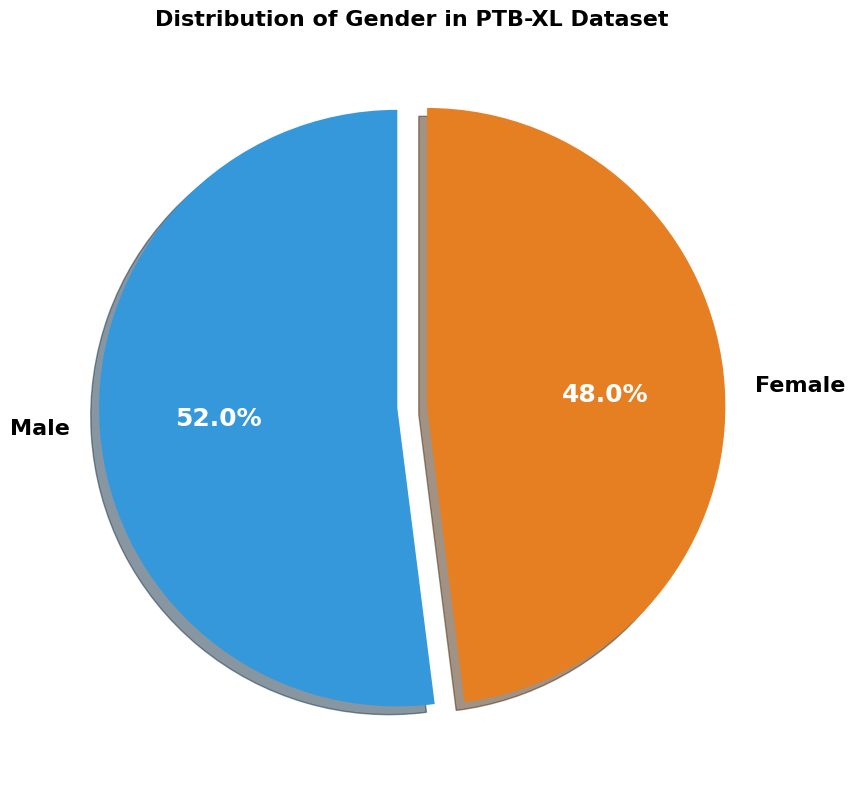

In [27]:
sex_counts = ptbxl['sex'].map({0: 'Male', 1: 'Female'}).value_counts()

colors = ['#3498db', '#e67e22'] 
plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(
    sex_counts.values,
    labels=sex_counts.index,
    colors=colors[:len(sex_counts)],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 16, 'fontweight': 'bold'},
    shadow=True,
    explode=[0.05] * len(sex_counts) 
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(18)

plt.title('Distribution of Gender in PTB-XL Dataset', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

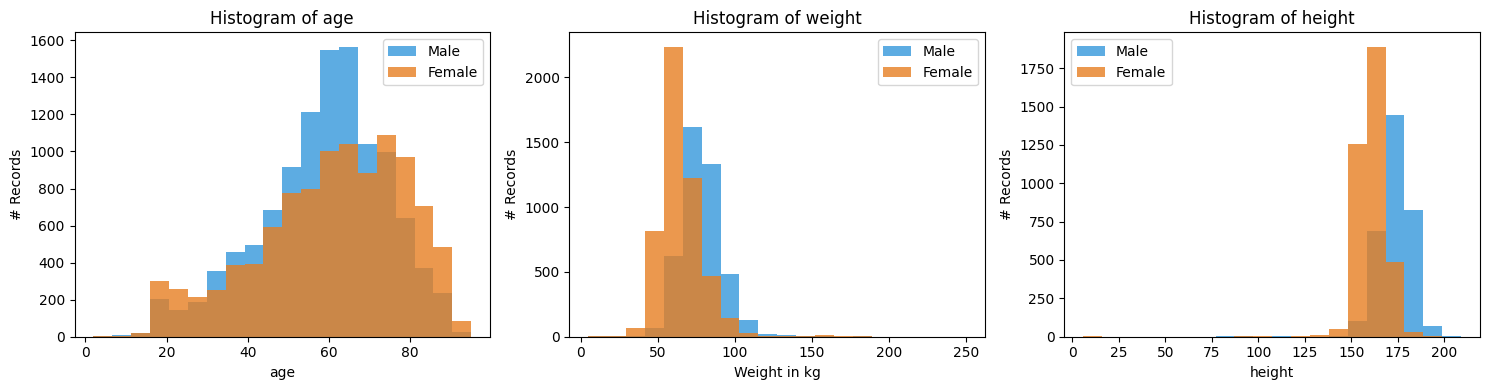

In [16]:
cols = ["age", "weight", "height"]
palette_map = {0: "#3498db", 1: "#e67e22"} 

plt.figure(figsize=(15, 4))
for i, col in enumerate(cols, 1):
    ax = plt.subplot(1, 3, i)
    
    sns.histplot(
        data=ptbxl,
        x=col,
        hue="sex",
        hue_order=[1, 0],
        bins=20,
        kde=False,
        palette=palette_map,
        alpha=0.8,
        ax=ax,
        legend=True,
        linewidth=0 
    )
    
    ax.set_title(f"Histogram of {col}")
    ax.legend(labels=['Male', 'Female'])
    ax.set_xlabel(col if col != "height" else "Height in cm")
    ax.set_xlabel(col if col != "weight" else "Weight in kg")
    ax.set_ylabel("# Records")
    ax.grid(False)

plt.tight_layout() 
plt.show()

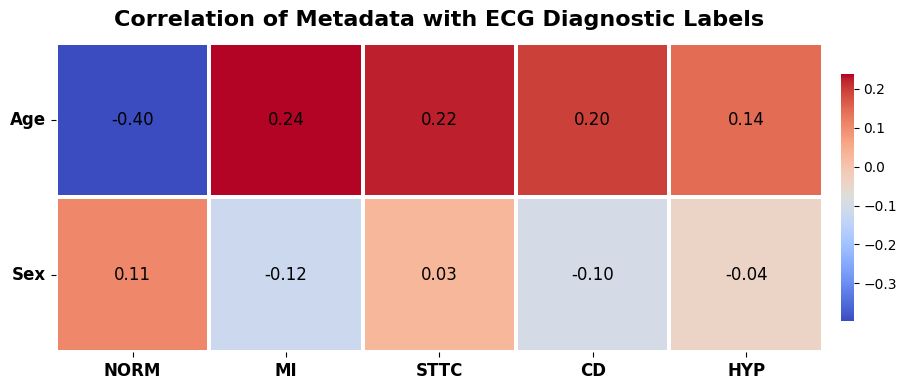

In [17]:
meta_cols = ["age", "sex"]
label_cols = ["NORM", "MI", "STTC", "CD", "HYP"]

corr_full = ptbxl[meta_cols + label_cols].corr()
correlation_matrix = corr_full.loc[meta_cols, label_cols]

plt.figure(figsize=(10, 4))

heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    annot_kws={"size": 12,"color": "black"},
    linewidths=1.5,
    linecolor="white",
    cbar_kws={"label": "","shrink": 0.8,"pad": 0.02}
)

plt.title("Correlation of Metadata with ECG Diagnostic Labels",fontsize=16, fontweight="bold", pad=12)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0, fontsize=12, fontweight="bold")
heatmap.set_yticklabels(["Age", "Sex"], rotation=0,fontsize=12,fontweight="bold")

plt.tight_layout()
plt.show()

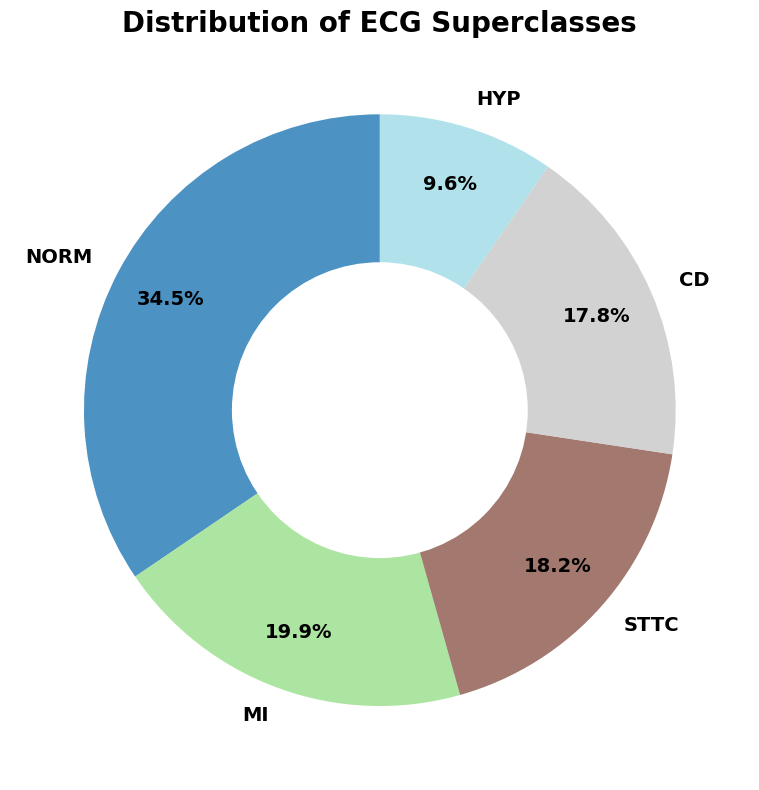

In [18]:
label_counts_df = ptbxl[SUPERCLASS_NAMES].sum().reset_index()
label_counts_df.columns = ['Label', 'Count']

plt.figure(figsize=(8, 8))

counts = label_counts_df['Count']
labels = label_counts_df['Label']

colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))
colors[:, -1] = 0.8 

wedge_props = {
    'edgecolor': 'none',
    'linewidth': 0
}

plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.80,
    textprops={'fontsize': 14, 'fontweight': 'bold'}  
)

centre_circle = plt.Circle((0, 0), 0.5, fc='white')
plt.gca().add_artist(centre_circle)

plt.title("Distribution of ECG Superclasses", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

## **Load Signals & Extract Labels** ##

In [74]:
def get_signal_and_labels(ecg_id, ptbxl_df, base_path, label_columns, use_hr=False):
    row = ptbxl_df[ptbxl_df['ecg_id'] == ecg_id].iloc[0]
    
    filename_col = 'filename_hr' if use_hr else 'filename_lr'
    filename = row[filename_col]
    
    signal_path = os.path.join(base_path, filename)
    
    signal, _ = wfdb.rdsamp(signal_path)
    
    labels = row[label_columns].values
    
    return signal, labels

In [75]:
def load_data_for_folds(ptbxl_df, base_path, label_cols, target_folds, use_hr=False):

    X_data = []
    Y_data = []

    if isinstance(target_folds, int):
        target_folds = [target_folds]
        
    filtered_df = ptbxl_df[ptbxl_df['strat_fold'].isin(target_folds)]
    
    for index, row in filtered_df.iterrows():
        ecg_id = row['ecg_id']
        signal, labels = get_signal_and_labels(ecg_id, ptbxl_df, base_path, label_cols, use_hr=use_hr)
        
        X_data.append(signal)
        Y_data.append(labels)
            
    X_data = np.array(X_data)
    Y_data = np.array(Y_data)
        
    return X_data, Y_data

In [105]:
TRAIN_FOLDS = list(range(1, 9))
VALIDATION_FOLD = 9
TEST_FOLD = 10

In [106]:
M_train = ptbxl.loc[ptbxl['strat_fold'].isin(TRAIN_FOLDS), ['age', 'sex']]
M_val = ptbxl.loc[ptbxl['strat_fold'] == VALIDATION_FOLD, ['age', 'sex']]
M_test = ptbxl.loc[ptbxl['strat_fold'] == TEST_FOLD, ['age', 'sex']]

In [107]:
base_path = '/kaggle/input/ptb-xl-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/' 

In [108]:
print("Starting data loading process")
X_train, Y_train = load_data_for_folds(ptbxl, base_path, SUPERCLASS_NAMES, TRAIN_FOLDS)
X_val, Y_val = load_data_for_folds(ptbxl, base_path, SUPERCLASS_NAMES, VALIDATION_FOLD)
X_test, Y_test = load_data_for_folds(ptbxl, base_path, SUPERCLASS_NAMES, TEST_FOLD)

Starting data loading process


In [109]:
print("\n\t\t Data Loading Summary")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}, M_train: {M_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}, M_train: {M_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}, M_train: {M_train.shape}")


		 Data Loading Summary
X_train shape: (17074, 1000, 12), Y_train shape: (17074, 5), M_train: (17074, 2)
X_val shape: (2152, 1000, 12), Y_val shape: (2152, 5), M_train: (17074, 2)
X_test shape: (2162, 1000, 12), Y_test shape: (2162, 5), M_train: (17074, 2)


## **Clean & Filter Signals** ##

In [110]:
FS = 100         # Sampling Frequency (Hz)
F_HIGH_PASS = 0.5  # High-pass cutoff for Baseline Wander (Hz)
F_LOW_PASS = 40.0  # Low-pass cutoff for Muscle Artifacts (Hz)
F_NOTCH = 50.0   # Notch frequency for Power Line Interference (Hz)
QUALITY_FACTOR = 30 # Q-factor for the notch filter

In [111]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    y = filtfilt(b, a, data)
    return y

In [112]:
def notch_filter(data, notch_freq, fs, Q):
    b, a = iirnotch(notch_freq, Q, fs)
    y = filtfilt(b, a, data)
    return y

In [113]:
def clean_ecg_dataset(X_data, fs=FS, f_high_pass=F_HIGH_PASS, f_low_pass=F_LOW_PASS, f_notch=F_NOTCH):    
    num_records, _, num_leads = X_data.shape
    
    for i in range(num_records):            
        for j in range(num_leads):
            signal = X_data[i, :, j]
            signal_filtered = butter_bandpass_filter(signal, f_high_pass, f_low_pass, fs)
            
            if f_notch > 1.0:
                 signal_filtered = notch_filter(signal_filtered, f_notch, fs, QUALITY_FACTOR)
            
            X_data[i, :, j] = signal_filtered
                
    return X_data

In [114]:
X_train = clean_ecg_dataset(X_train)
X_val = clean_ecg_dataset(X_val)
X_test = clean_ecg_dataset(X_test)

In [26]:
def plot_sample_signals(X_data, num_samples=5):
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    
    num_records = min(num_samples, X_data.shape[0])
    
    for i in range(num_records):
        fig, axes = plt.subplots(4, 3, figsize=(18, 12))
        fig.suptitle(f'ECG Record Sample {i + 1} - 12 Leads (Time Domain)', fontsize=16)
        
        axes = axes.flatten()
        
        signal = X_data[i]
        
        for lead_index in range(12):
            ax = axes[lead_index]
            lead_name = lead_names[lead_index]
            
            ax.plot(signal[:, lead_index], color='blue', linewidth=1)
            ax.set_title(f'Lead {lead_name}', fontsize=10)
            ax.set_xticks([]) 
            ax.set_yticks([])
            ax.grid(True, linestyle='--', alpha=0.5)

        for j in range(len(lead_names), len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

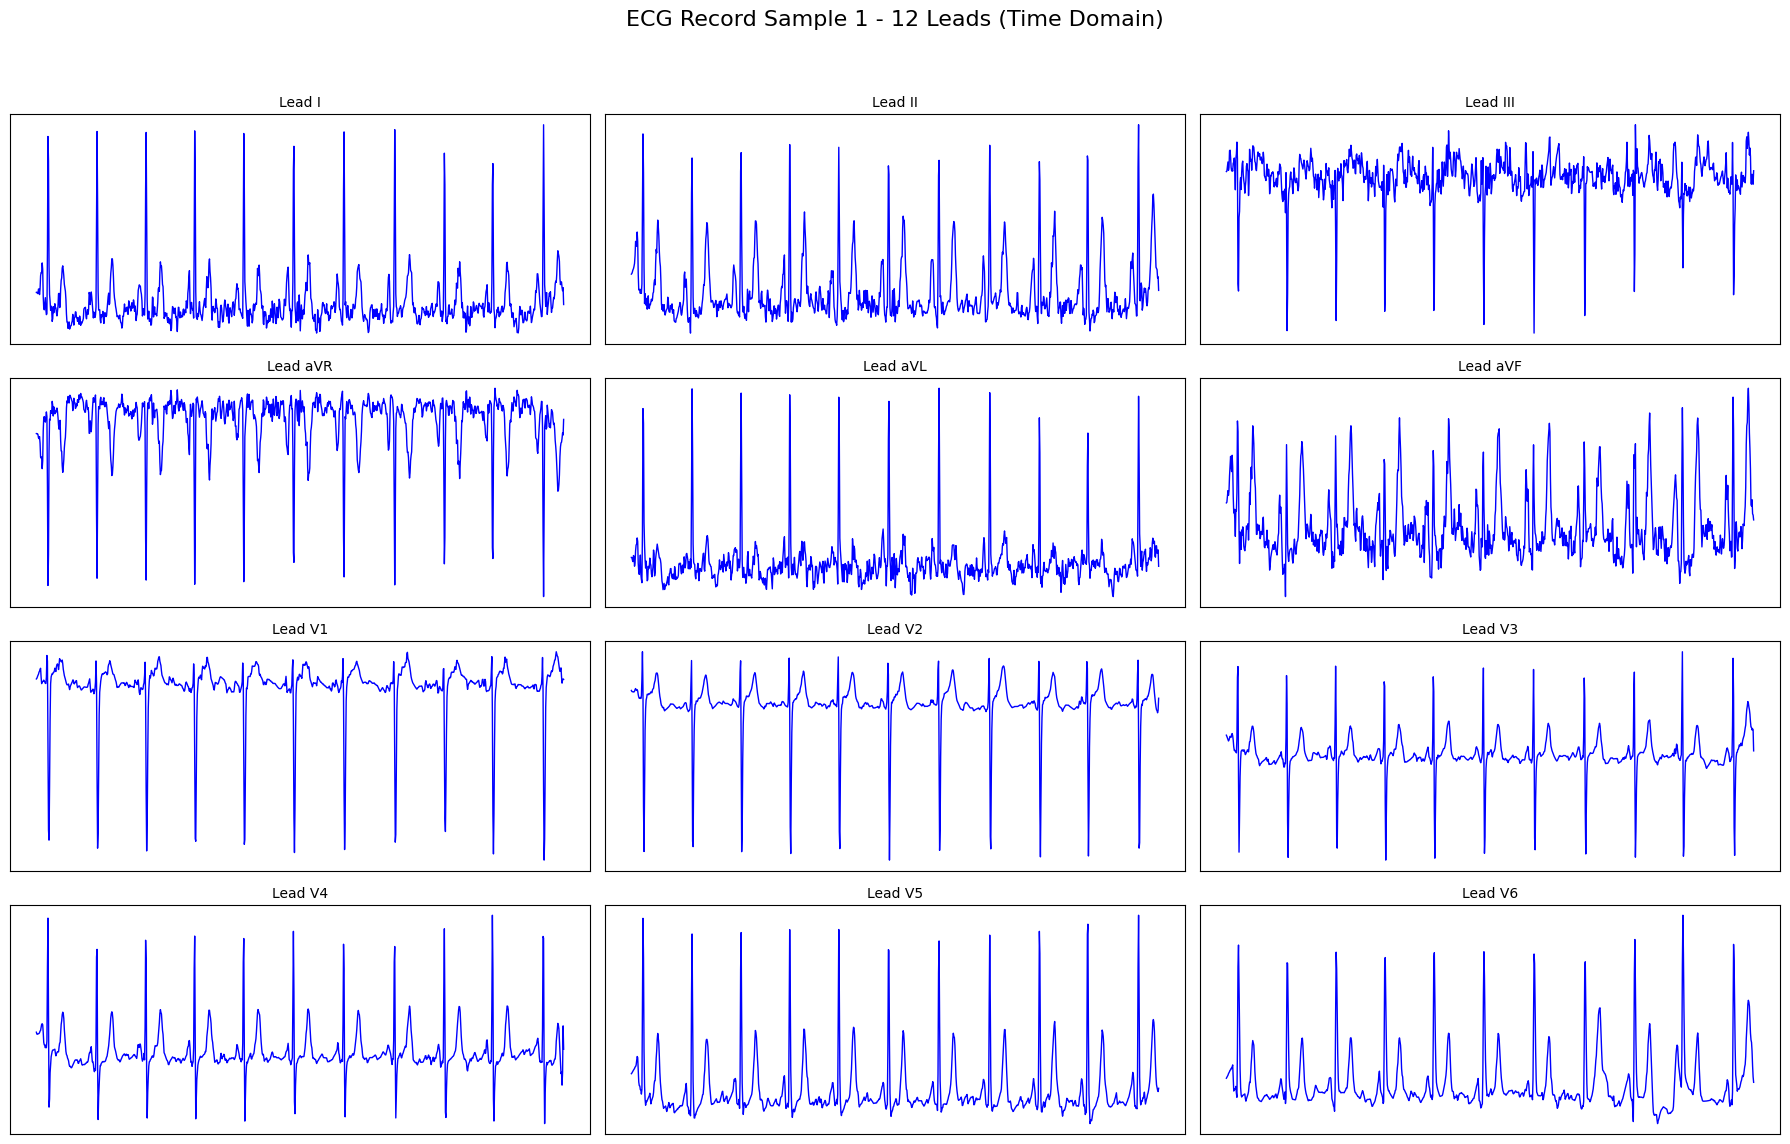

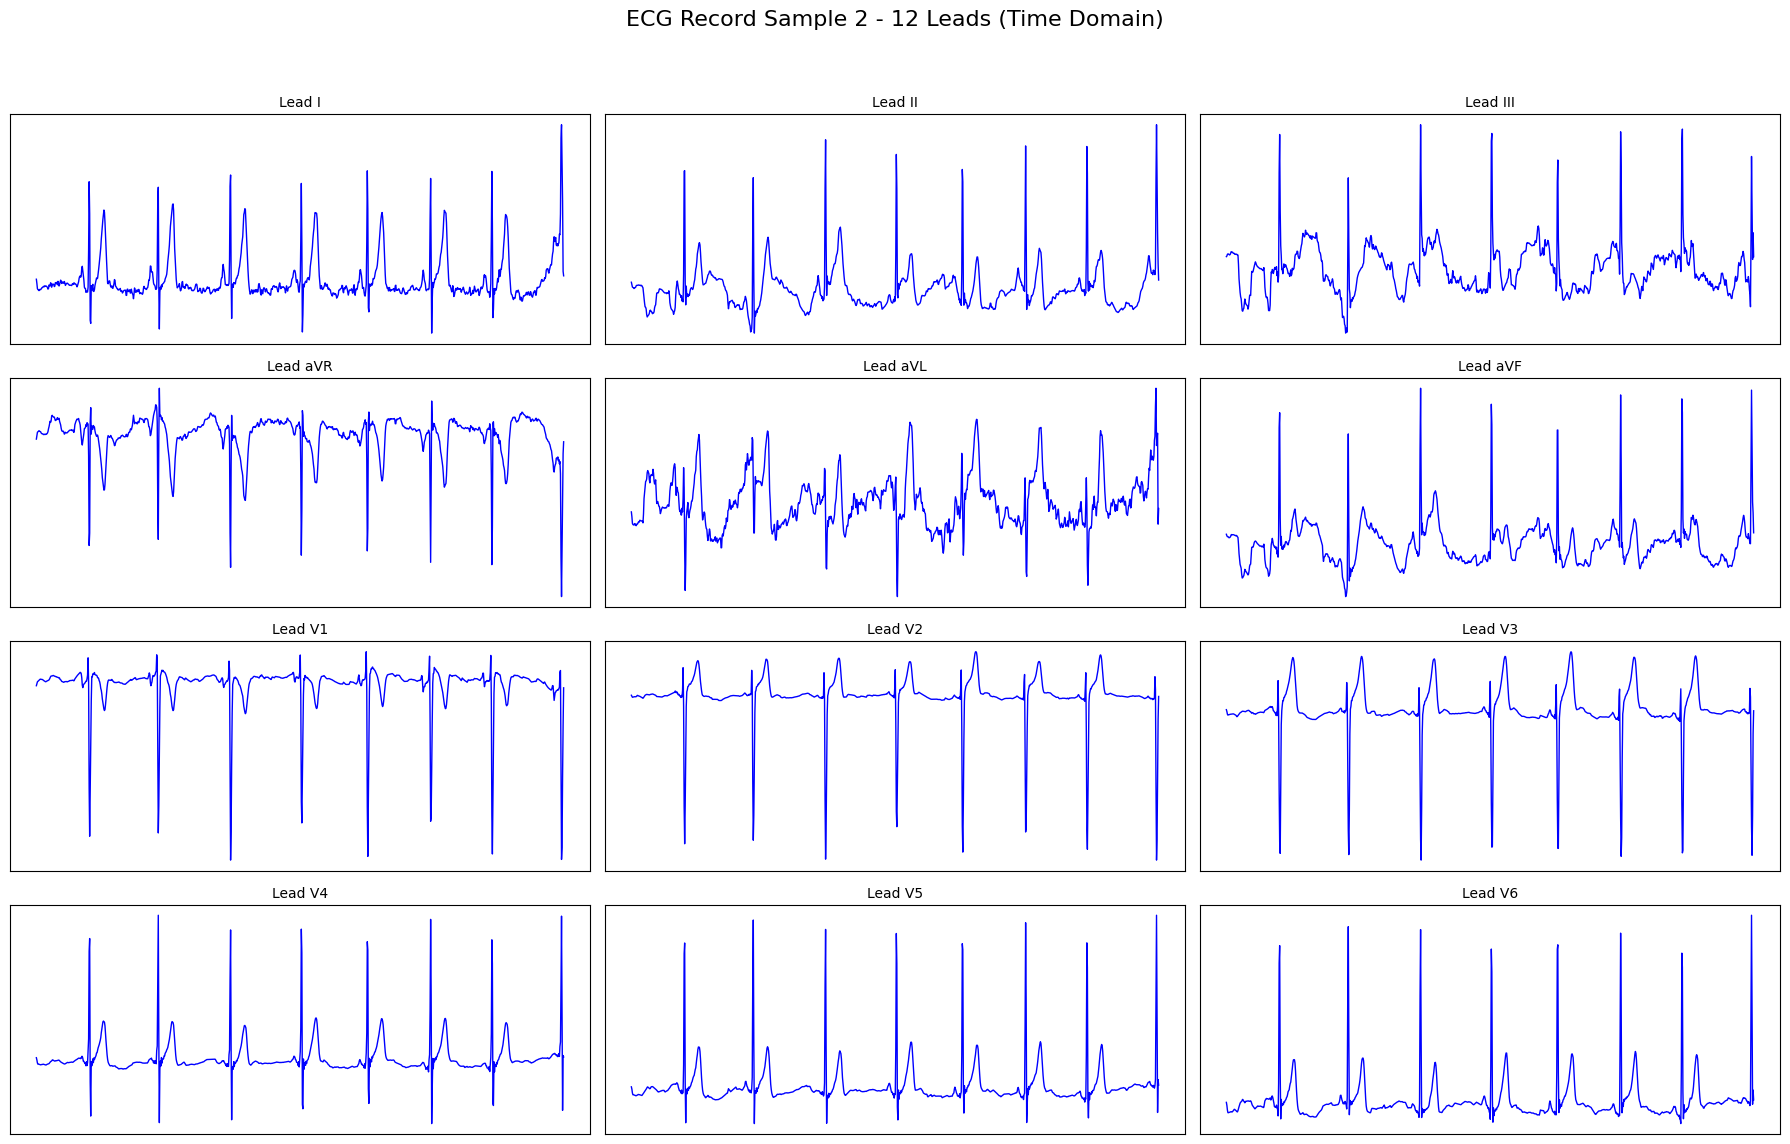

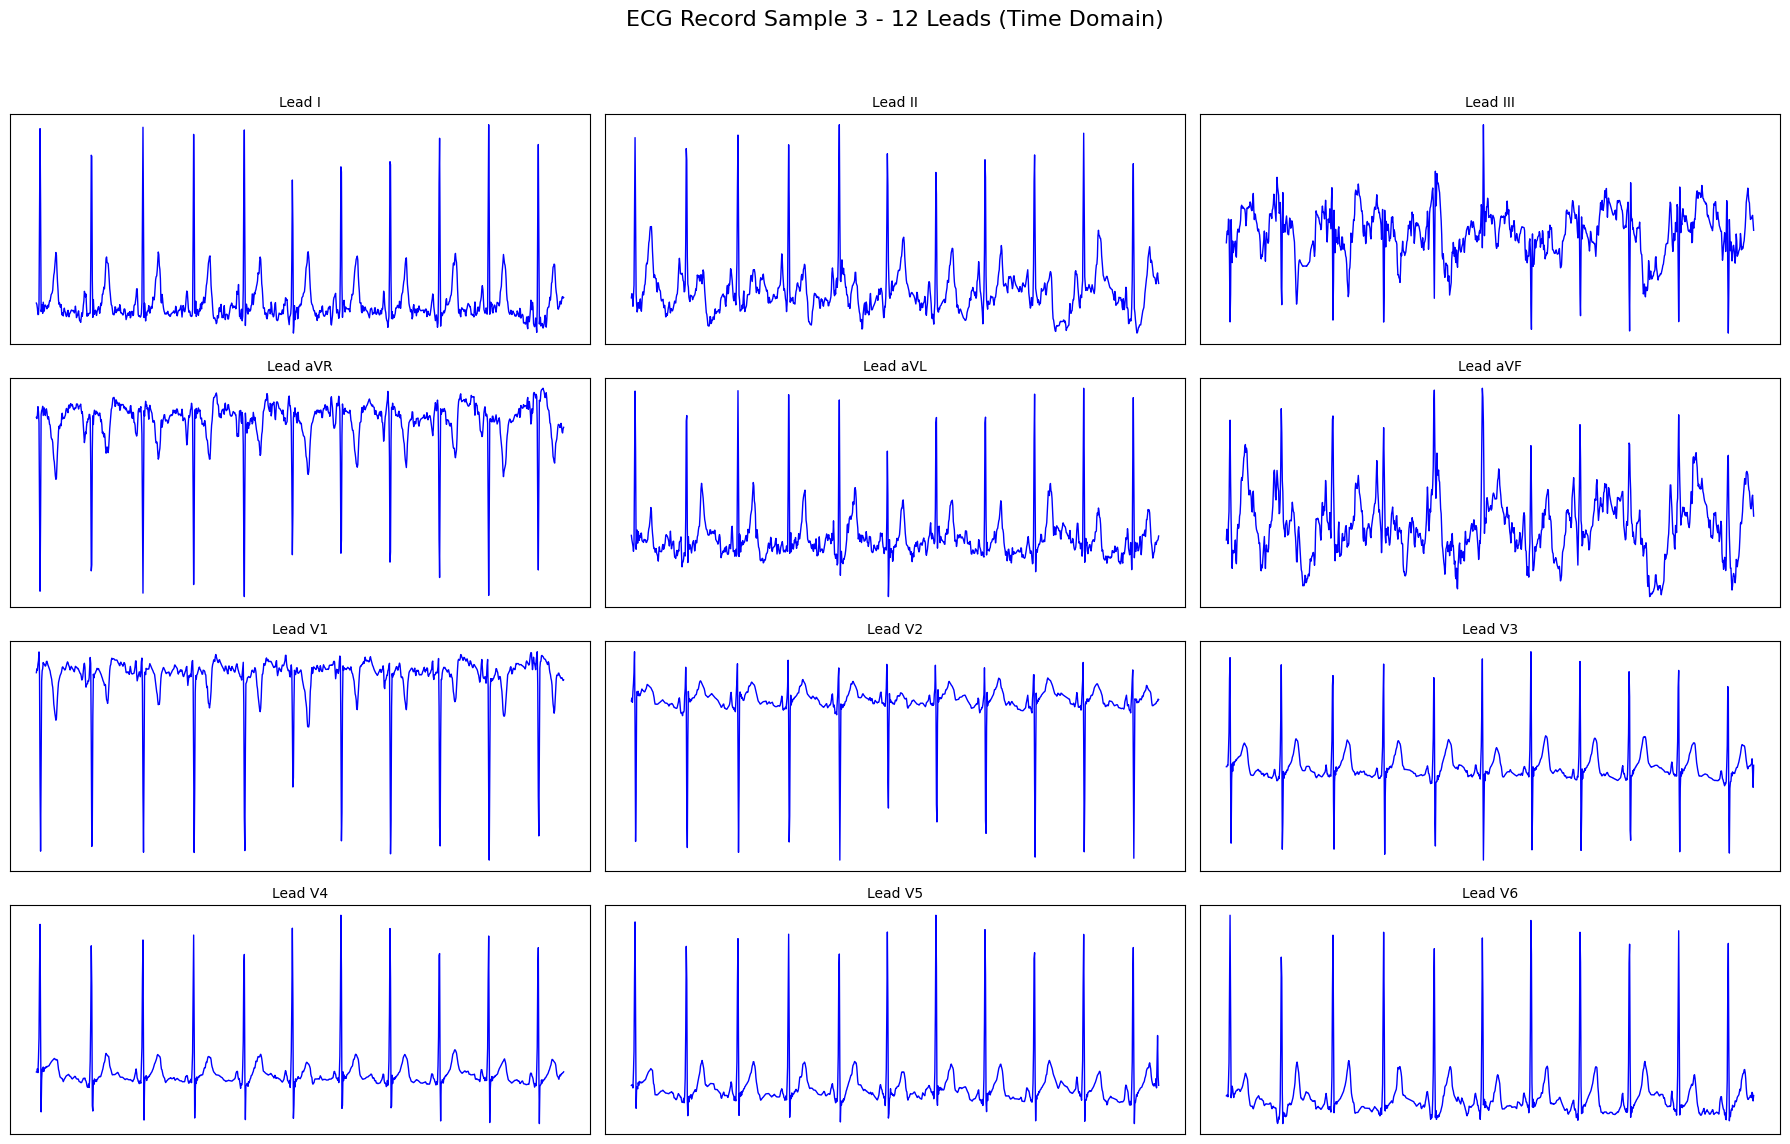

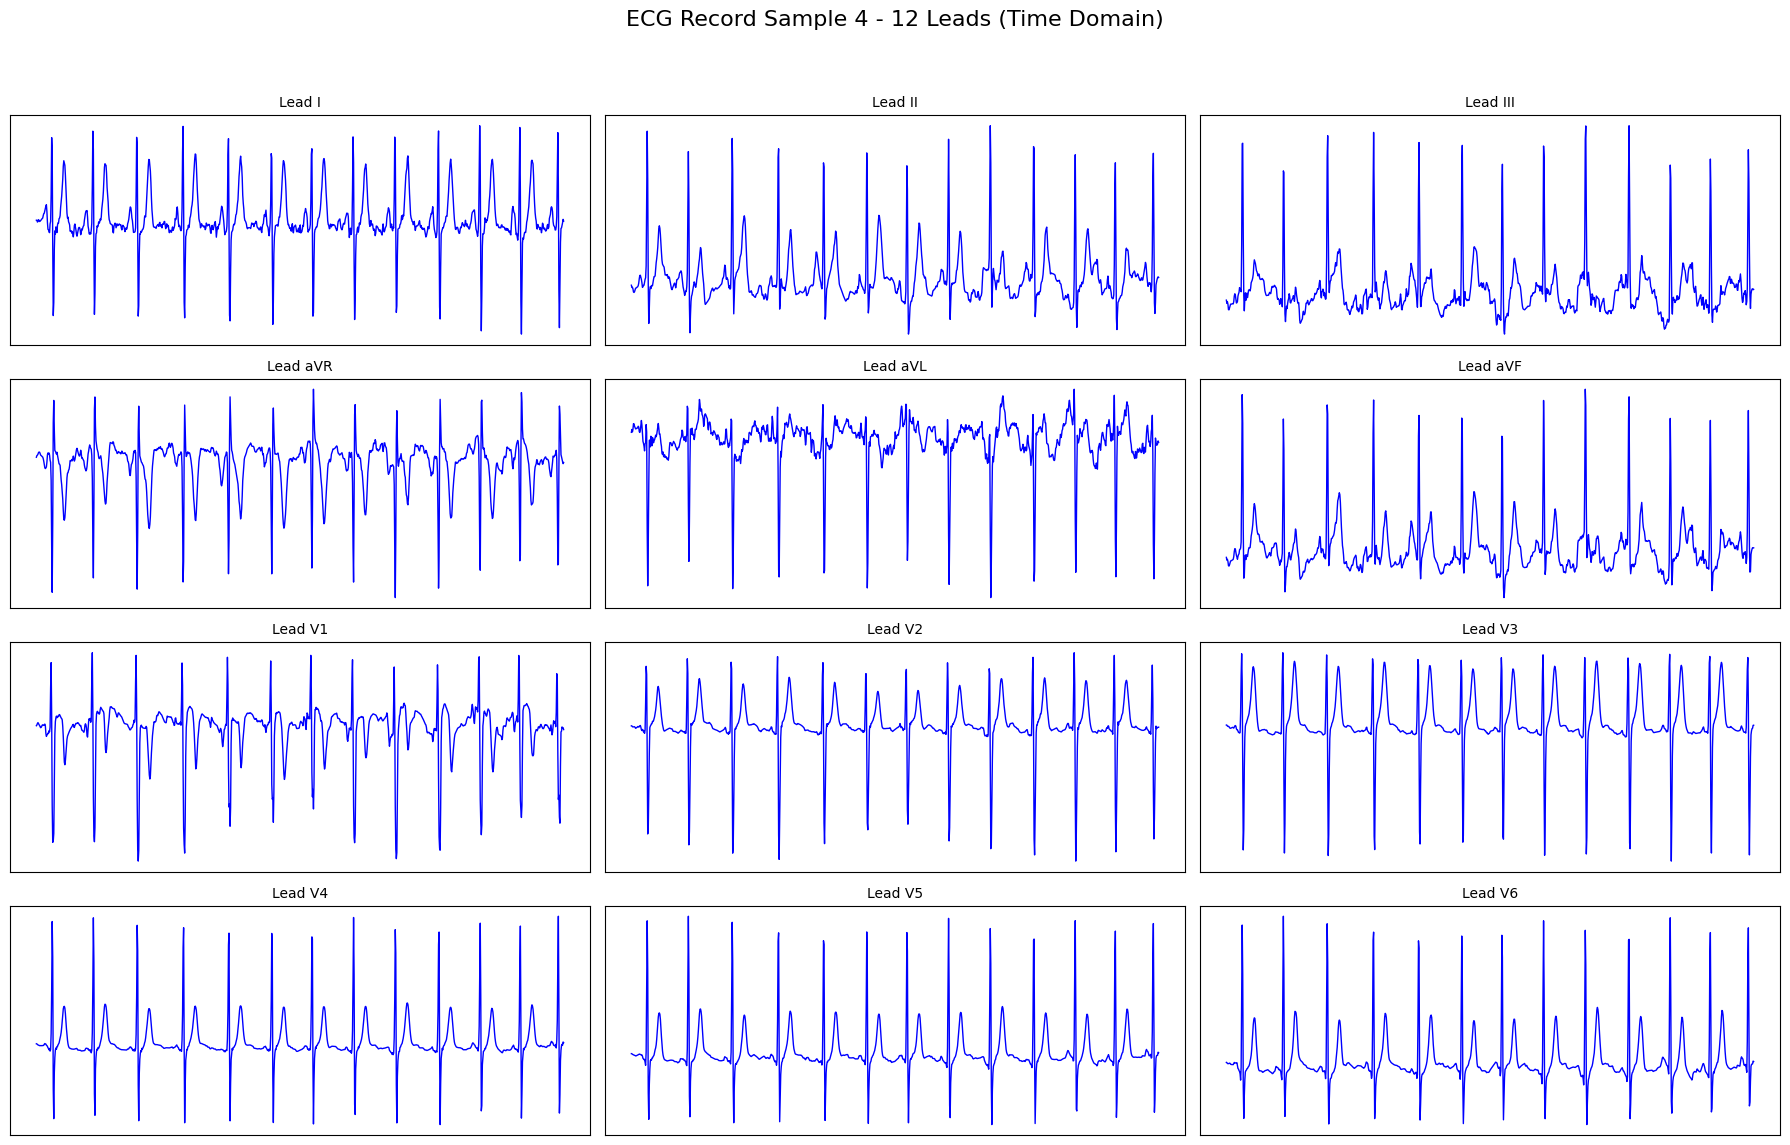

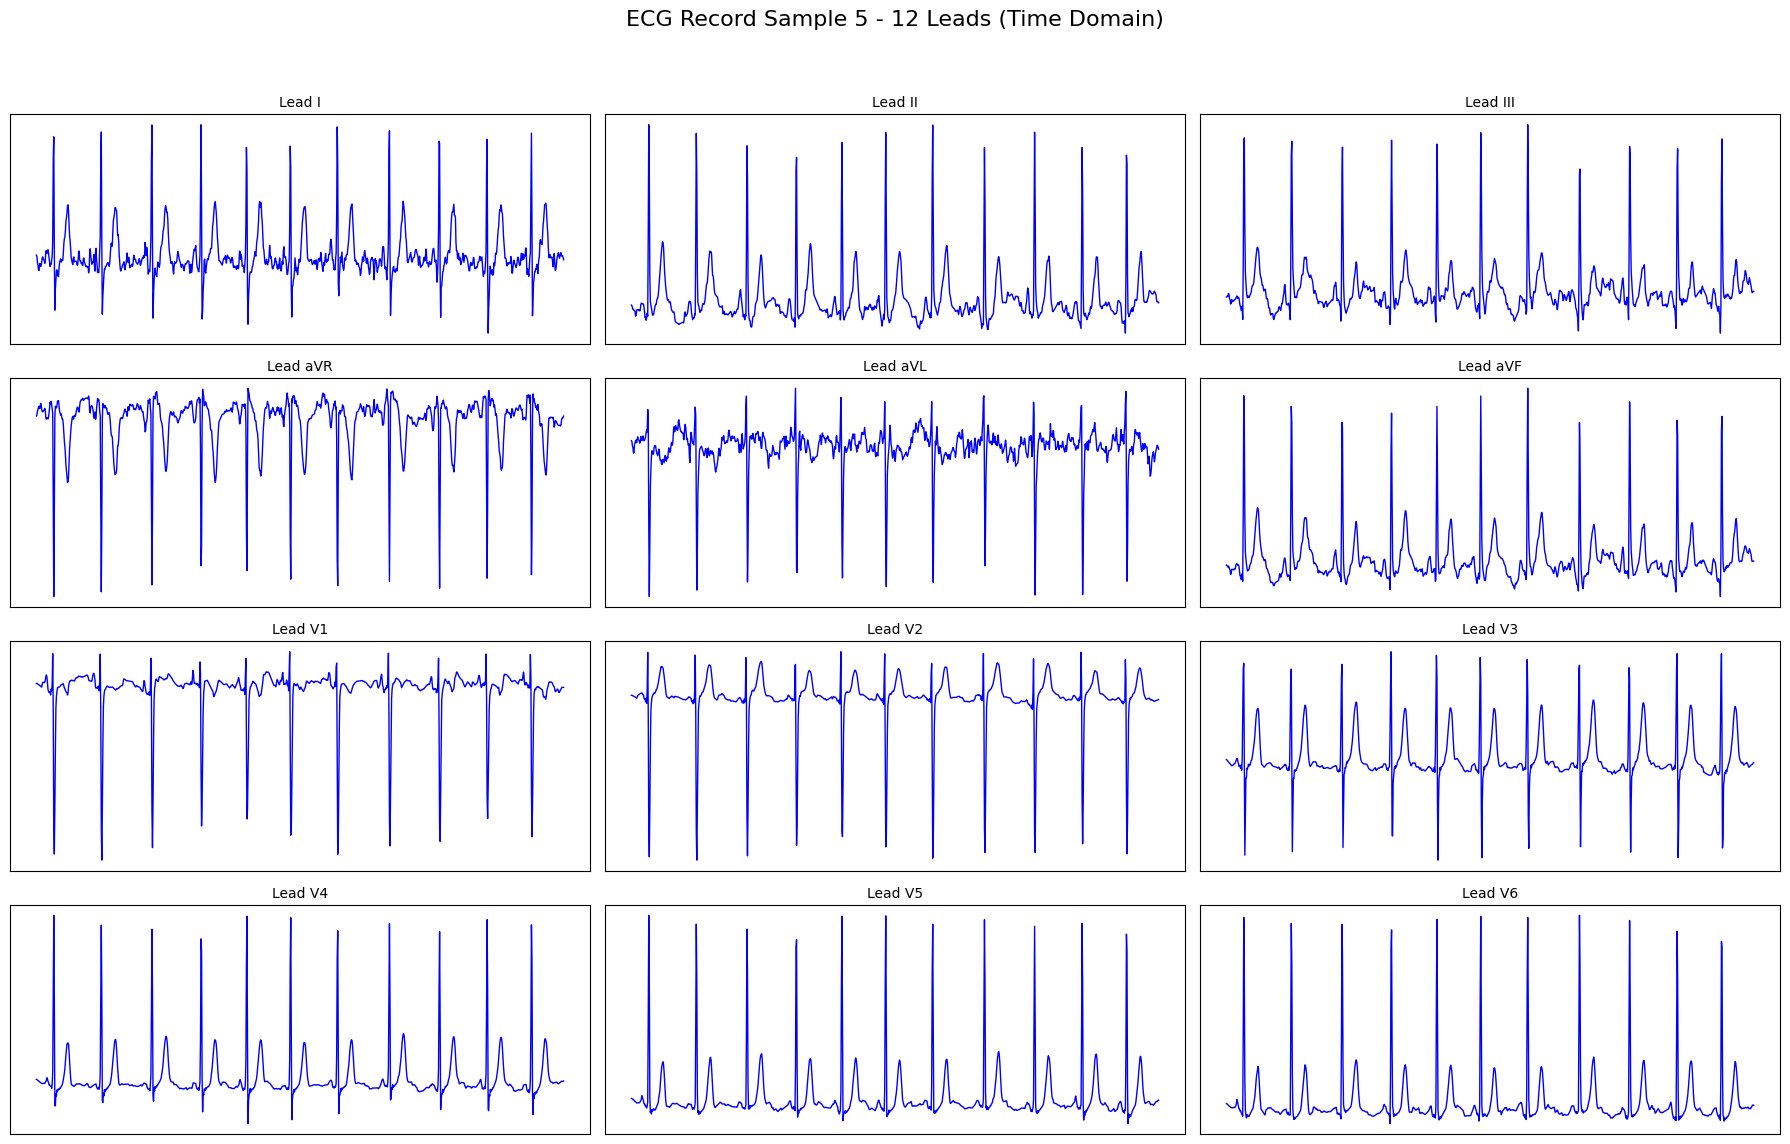

In [30]:
plot_sample_signals(X_train)

## **Feature Extraction (Time-Frequency Transformation)** ##

In [32]:
def apply_stft_to_dataset(X_data, fs=500, nperseg=64, noverlap=32):
    
    num_records, num_samples, num_leads = X_data.shape
    
    _, _, z_test = stft(X_data[0, :, 0], fs=fs, nperseg=nperseg, noverlap=noverlap)
    num_freq_bins, num_time_bins = z_test.shape

    X_stft = np.zeros((num_records, num_freq_bins, num_time_bins, num_leads), dtype=np.float32)

    for i in range(num_records):
        for j in range(num_leads):                
            _, _, Zxx = stft(X_data[i, :, j], fs=fs, nperseg=nperseg, noverlap=noverlap)
                
            X_stft[i, :, :, j] = np.abs(Zxx)
                
    return X_stft

In [33]:
FS = 100 # Sampling frequency for PTB-XL HR data
N_PER_SEG = 64 # STFT window size (samples)
N_OVERLAP = 32 # STFT overlap (samples)

In [34]:
X_train = apply_stft_to_dataset(X_train, fs=FS, nperseg=N_PER_SEG, noverlap=N_OVERLAP)
X_val = apply_stft_to_dataset(X_val, fs=FS, nperseg=N_PER_SEG, noverlap=N_OVERLAP)
X_test = apply_stft_to_dataset(X_test, fs=FS, nperseg=N_PER_SEG, noverlap=N_OVERLAP)

In [35]:
print("\n\t\t Data Summary After SIFT")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")


		 Data Summary After SIFT
X_train shape: (17074, 33, 33, 12), Y_train shape: (17074, 5)
X_val shape: (2152, 33, 33, 12), Y_val shape: (2152, 5)
X_test shape: (2162, 33, 33, 12), Y_test shape: (2162, 5)


In [36]:
def plot_sample_spectrograms(X_stft_data, num_samples=5):

    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    num_records = min(num_samples, X_stft_data.shape[0])

    for i in range(num_records):
        fig, axes = plt.subplots(4,3 , figsize=(18, 12))
        fig.suptitle(f'ECG Record Sample {i + 1} - 12 Leads Spectrograms (STFT Magnitude)', fontsize=16)
        
        axes = axes.flatten()
        
        spectrograms = X_stft_data[i] 
        
        for lead_index in range(12):
            ax = axes[lead_index]
            lead_name = lead_names[lead_index]
            
            im = ax.imshow(spectrograms[:, :, lead_index], 
                           aspect='auto', 
                           origin='lower', 
                           cmap='viridis') 
            
            ax.set_title(f'Lead {lead_name}', fontsize=10)
            ax.set_xlabel("Time Segments")
            ax.set_ylabel("Frequency Bins")

        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax, label='Magnitude (Intensity)')
            
        plt.tight_layout(rect=[0, 0.03, 0.90, 0.95])
        plt.show()

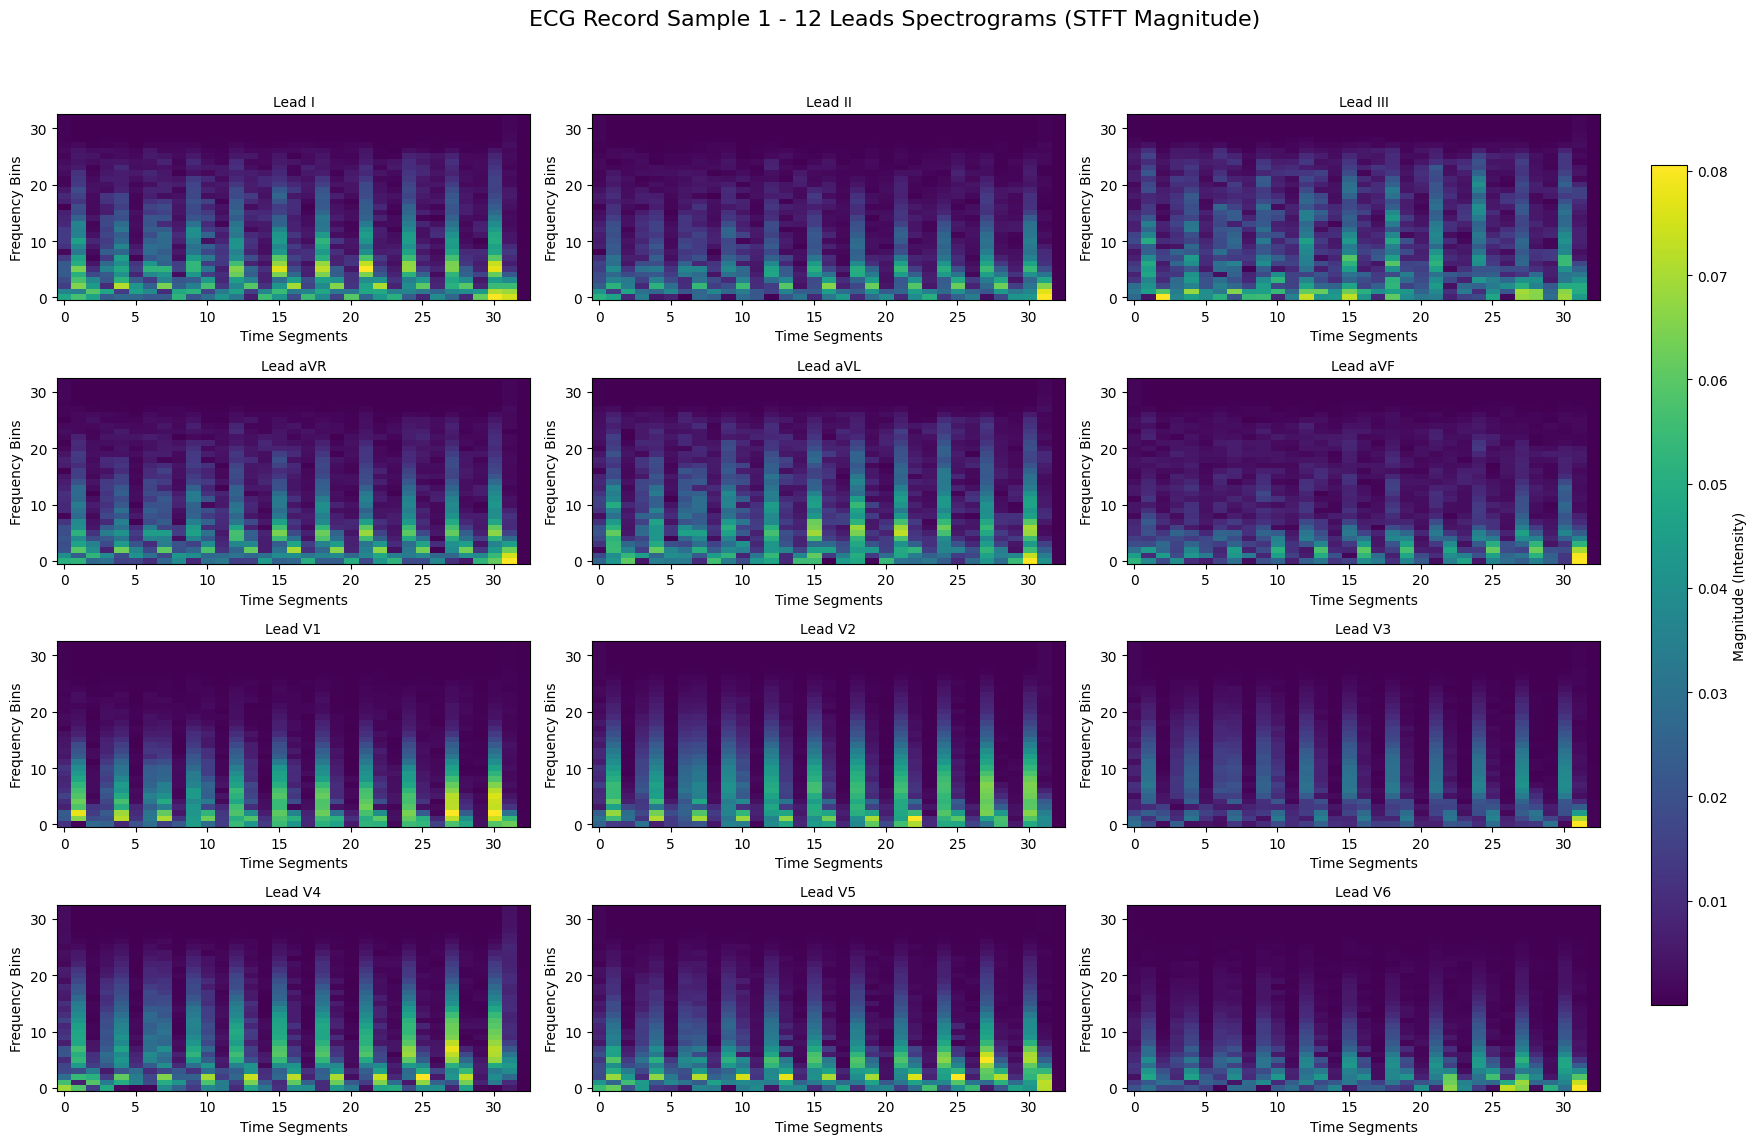

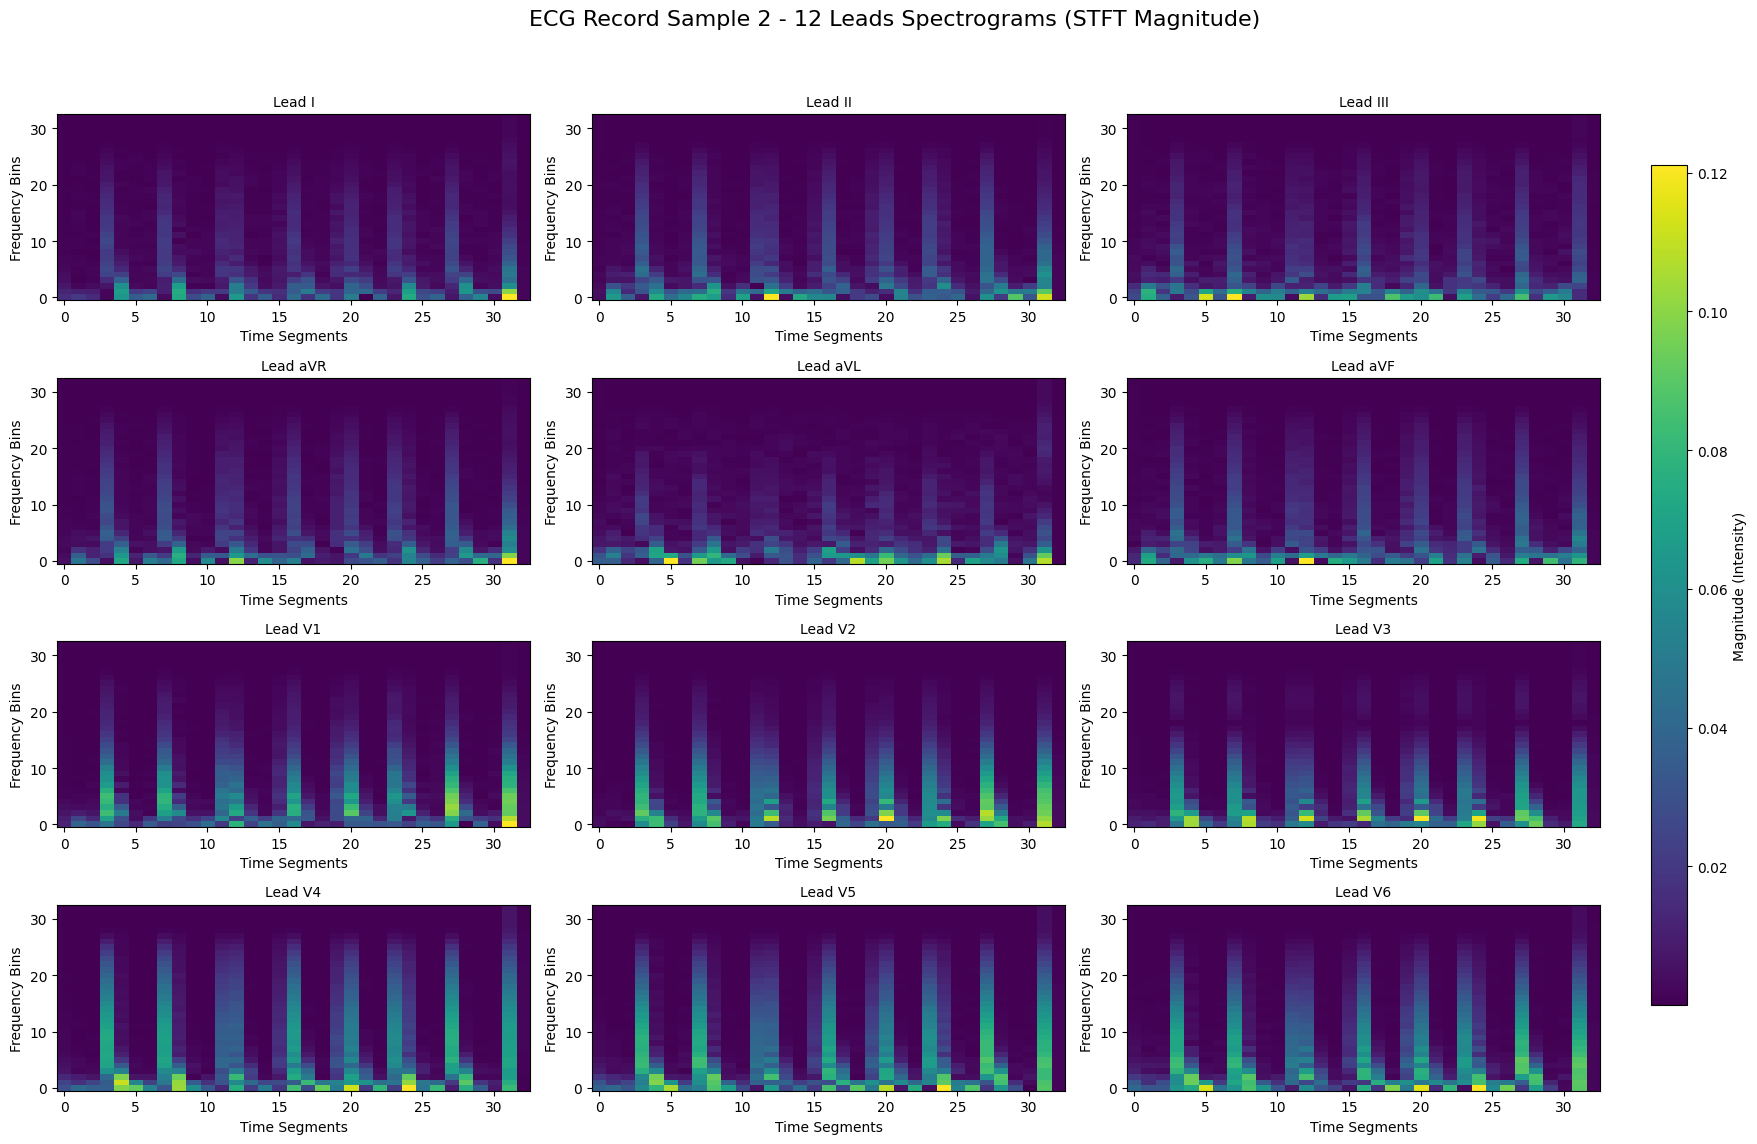

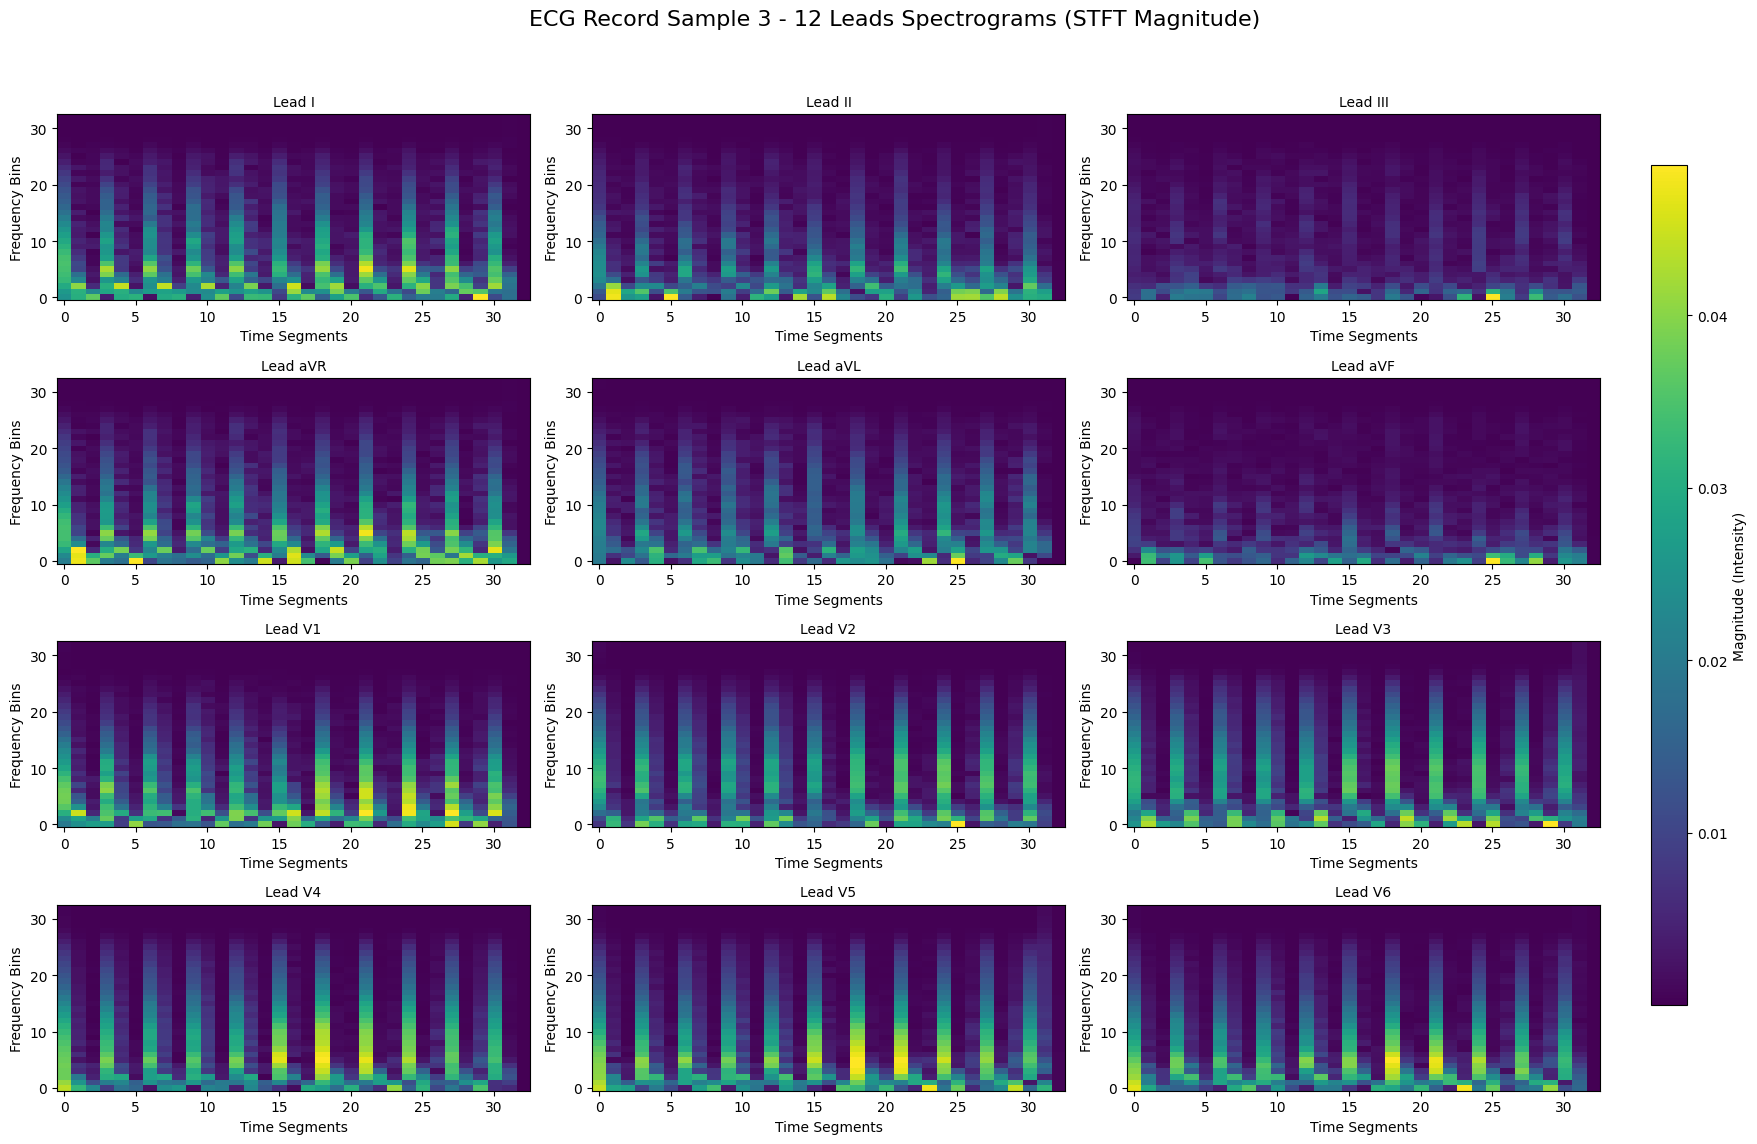

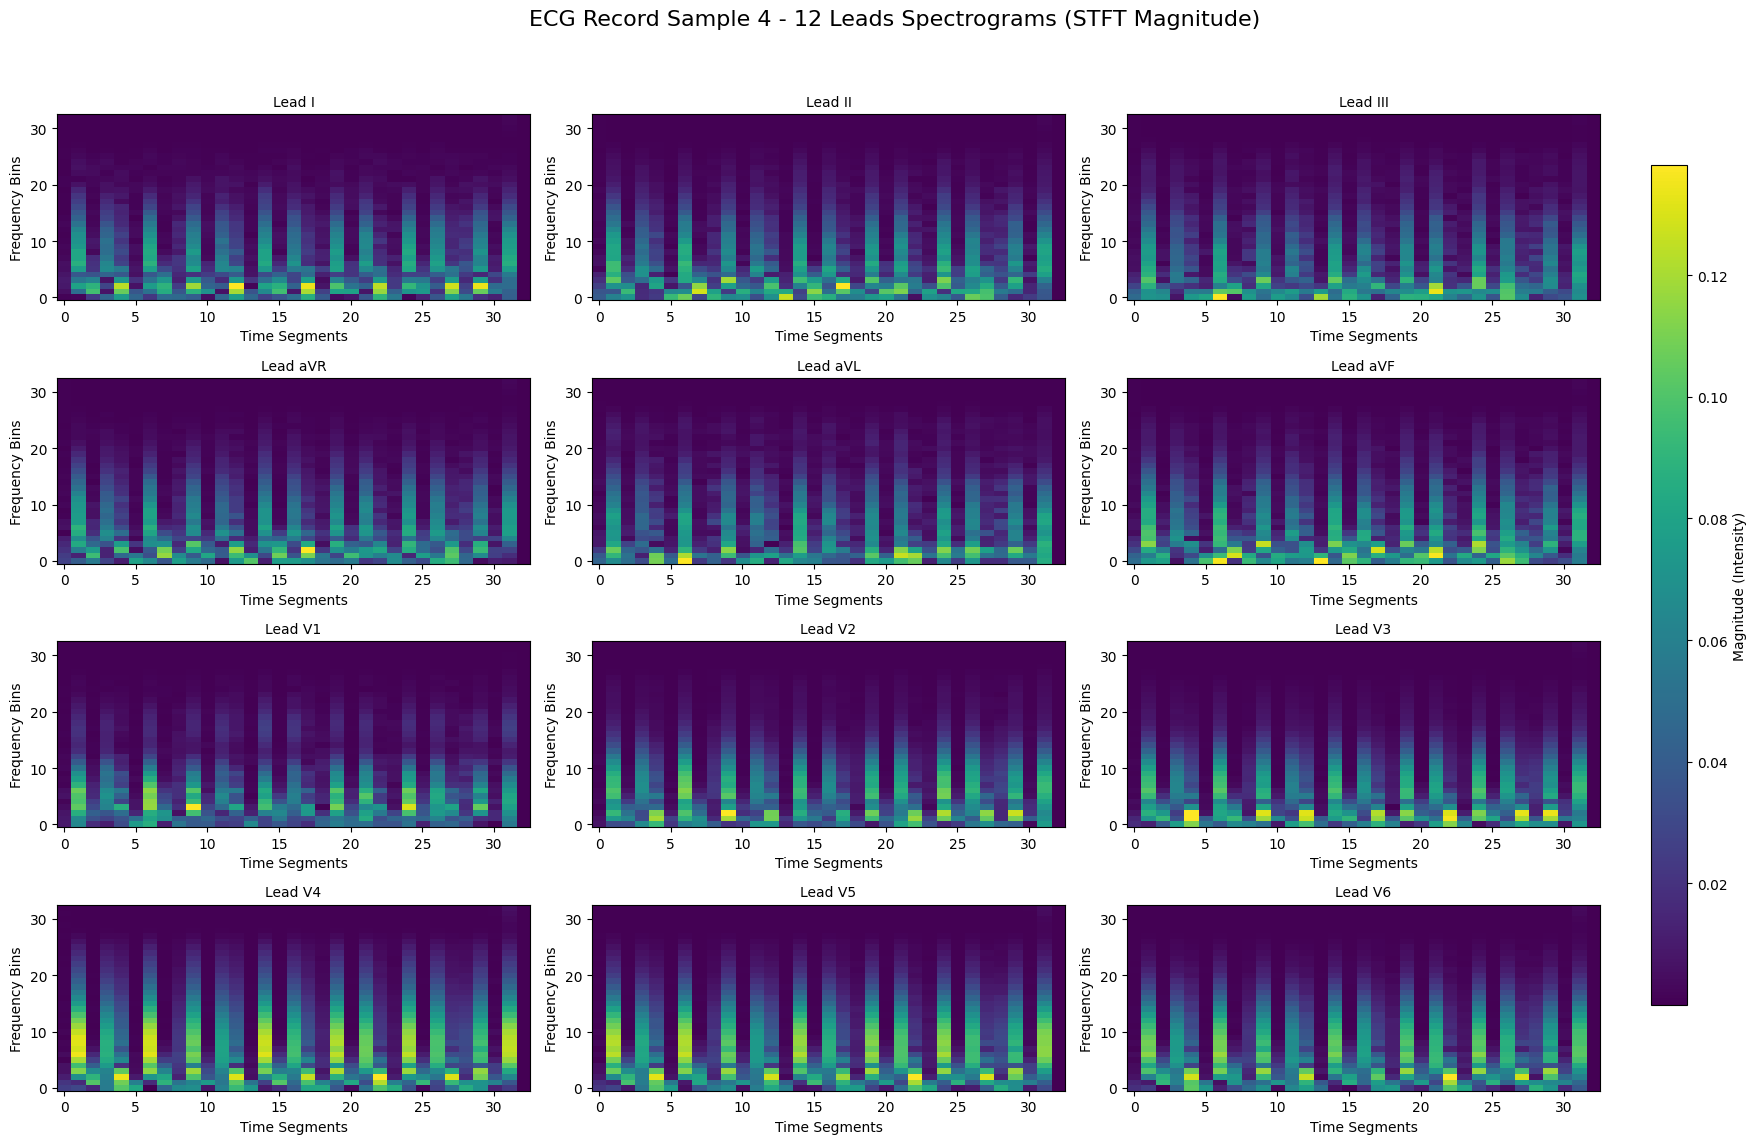

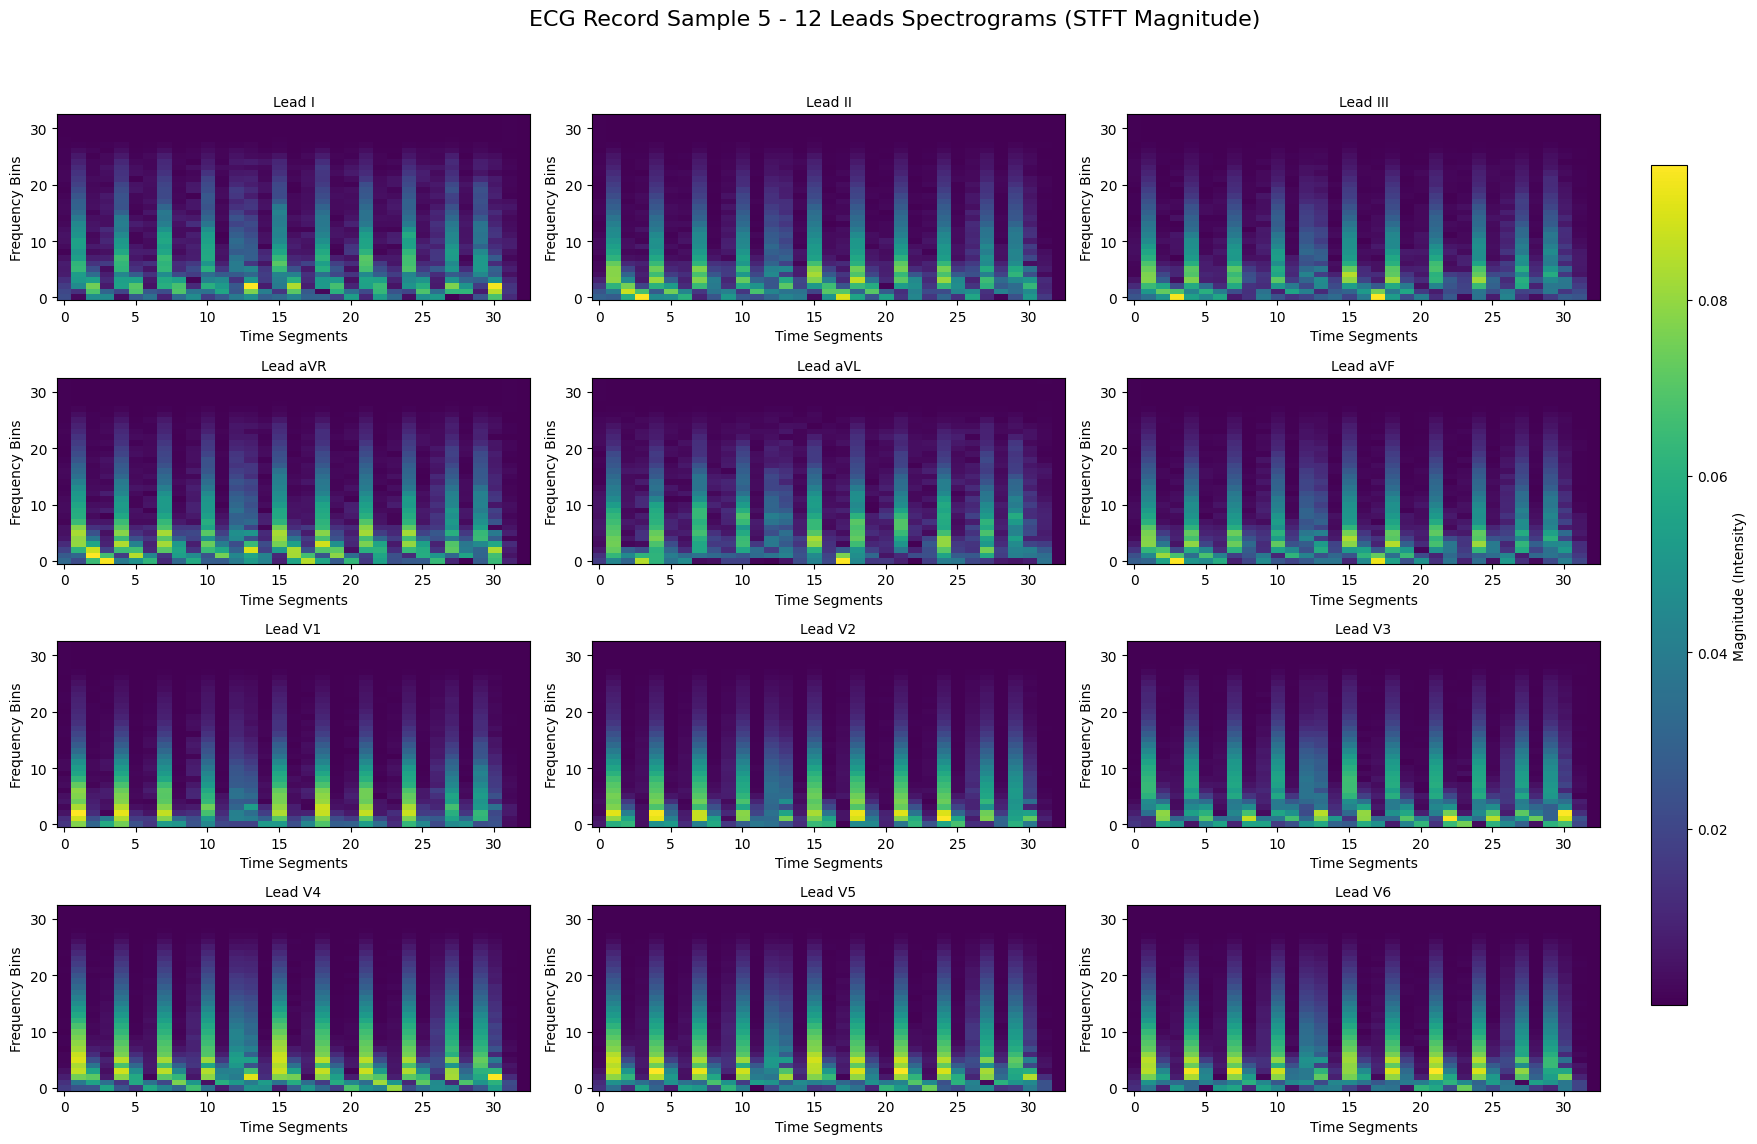

In [37]:
plot_sample_spectrograms(X_train, num_samples=5) 

## **Data Standardization** ##

In [115]:
def process_data(X_data, mean_val=None, std_val=None, epsilon=1e-8):
    if mean_val is None or std_val is None:
        mean_val = X_data.mean()
        std_val = X_data.std()

    X_data_scaled = (X_data - mean_val) / (std_val + epsilon)
    return X_data_scaled.astype(np.float32), mean_val, std_val


In [116]:
X_train, global_min, global_max = process_data(X_train)
X_val, _, _ = process_data(X_val, global_min, global_max)
X_test, _, _ = process_data(X_test, global_min, global_max)

In [117]:
def convert_to_binary_targets(y_array):
    binary_targets_bool = y_array > 0.0
    binary_targets = binary_targets_bool.astype(np.int32)
    
    return binary_targets

In [118]:
Y_train = convert_to_binary_targets(Y_train)
Y_val = convert_to_binary_targets(Y_val)
Y_test = convert_to_binary_targets(Y_test)

In [119]:
Y_train.shape

(17074, 5)

# **Architecture Building & Setup** #

## **Stacked xLSTM Classifier** ##

In [ ]:
class StackedParallelxLSTMClassifier(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        self.embedding = nn.Linear(config['input_shape'][1], config['embedding_dim'])
        self.embedding_norm = nn.LayerNorm(config['embedding_dim'])
        self.embedding_act = nn.ReLU()
        
        slstm_config = sLSTMBlockConfig(
            slstm=sLSTMLayerConfig(
                num_heads=config['num_heads'],
                conv1d_kernel_size=4,
                bias_init="powerlaw_blockdependent",
            ),
            feedforward=FeedForwardConfig(
                proj_factor=1.3,
                act_fn="gelu",
            ),
        )
        
        slstm_stack_config = xLSTMBlockStackConfig(
            slstm_block=slstm_config,
            context_length=config['input_shape'][0],
            num_blocks=2,
            embedding_dim=config['embedding_dim'],
            slstm_at=[0, 1],  
        )
        self.slstm_branch = xLSTMBlockStack(slstm_stack_config)
        
        mlstm_config = mLSTMBlockConfig(
            mlstm=mLSTMLayerConfig(
                num_heads=config['num_heads'],
                conv1d_kernel_size=4,
            ),
        )
        
        mlstm_stack_config = xLSTMBlockStackConfig(
            mlstm_block=mlstm_config,
            context_length=config['input_shape'][0],
            num_blocks=2,
            embedding_dim=config['embedding_dim'],
            slstm_at=[], 
        )
        self.mlstm_branch = xLSTMBlockStack(mlstm_stack_config)
        
        self.dropout = nn.Dropout(config['dropout'])
        
        self.metadata_net = nn.Sequential(
            nn.Linear(config['metadata_dim'], 32),
            nn.ReLU(),
            nn.Dropout(config['dropout'])
        )
        
        combined_dim = (config['embedding_dim'] * 2) + 32
        
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(128, config['num_classes']),
            nn.Sigmoid()
        )
        
        self.criterion = nn.BCELoss()
        
    def forward(self, x, m):
        # Embedding
        x = self.embedding(x)
        x = self.embedding_norm(x)
        x = self.embedding_act(x)
        
        x_s = self.slstm_branch(x)
        x_m = self.mlstm_branch(x)
        
        x_fused = (x_s + x_m) / 2.0
        x_fused = self.dropout(x_fused)
        
        x_avg = torch.mean(x_fused, dim=1)
        x_max, _ = torch.max(x_fused, dim=1)
        x_pool = torch.cat([x_avg, x_max], dim=1)

        m_out = self.metadata_net(m)
        combined = torch.cat([x_pool, m_out], dim=1)

        output = self.classifier(combined)
        return output
        
    def training_step(self, batch, batch_idx):
        x, m, y = batch
        y_pred = self(x, m)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, m, y = batch
        y_pred = self(x, m)
        loss = self.criterion(y_pred, y)
        try:
            y_true = y.cpu().numpy()
            y_scores = y_pred.cpu().numpy()
            y_pred_bin = (y_scores > 0.5).astype(int)
            
            auc = roc_auc_score(y_true, y_scores, average='macro')
            self.log('val_auc', auc, prog_bar=True)
            
            f1 = f1_score(y_true, y_pred_bin, average='macro', zero_division=0)
            self.log('val_f1', f1, prog_bar=True)
            
            acc = np.mean(y_true == y_pred_bin)
            self.log('val_acc', acc, prog_bar=True)
            
        except Exception as e:
            pass
            
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, m, y = batch
        y_pred = self(x, m)
        loss = self.criterion(y_pred, y)
        self.log('test_loss', loss)
        return {'y_true': y, 'y_pred': y_pred}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['learning_rate'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

## **Hierarchical xLSTM Classifier** ##

In [ ]:
class HierarchicalParallelxLSTMClassifier(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        self.embedding = nn.Linear(config['input_shape'][1], config['embedding_dim'])
        self.embedding_norm = nn.LayerNorm(config['embedding_dim'])
        self.embedding_act = nn.ReLU()        
        self.num_blocks = config.get('num_blocks', 2)
        self.slstm_blocks = nn.ModuleList()
        self.mlstm_blocks = nn.ModuleList()
        
        for i in range(self.num_blocks):
            slstm_config = sLSTMBlockConfig(
                slstm=sLSTMLayerConfig(
                    num_heads=config['num_heads'],
                    conv1d_kernel_size=4,
                    bias_init="powerlaw_blockdependent",
                ),
                feedforward=FeedForwardConfig(
                    proj_factor=1.3,
                    act_fn="gelu",
                ),
            )
            
            slstm_stack_config = xLSTMBlockStackConfig(
                slstm_block=slstm_config,
                context_length=config['input_shape'][0],
                num_blocks=1,  
                embedding_dim=config['embedding_dim'],
                slstm_at=[0],
            )
            self.slstm_blocks.append(xLSTMBlockStack(slstm_stack_config))
            
            mlstm_config = mLSTMBlockConfig(
                mlstm=mLSTMLayerConfig(
                    num_heads=config['num_heads'],
                    conv1d_kernel_size=4,
                ),
            )
            
            mlstm_stack_config = xLSTMBlockStackConfig(
                mlstm_block=mlstm_config,
                context_length=config['input_shape'][0],
                num_blocks=1,  # Single block per layer
                embedding_dim=config['embedding_dim'],
                slstm_at=[],
            )
            self.mlstm_blocks.append(xLSTMBlockStack(mlstm_stack_config))
        
        self.dropout = nn.Dropout(config['dropout'])
        
        self.metadata_net = nn.Sequential(
            nn.Linear(config['metadata_dim'], 32),
            nn.ReLU(),
            nn.Dropout(config['dropout'])
        )
        
        combined_dim = (config['embedding_dim'] * 2) + 32
        
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(128, config['num_classes']),
            nn.Sigmoid()
        )
        
        self.criterion = nn.BCELoss()
        
    def forward(self, x, m):
        # Embedding
        x = self.embedding(x)
        x = self.embedding_norm(x)
        x = self.embedding_act(x)
        
        for i in range(self.num_blocks):
            x_s = self.slstm_blocks[i](x)
            x_m = self.mlstm_blocks[i](x)            
            x = (x_s + x_m) / 2.0
            x = self.dropout(x)
        
        x_avg = torch.mean(x, dim=1)
        x_max, _ = torch.max(x, dim=1)
        x_pool = torch.cat([x_avg, x_max], dim=1)

        m_out = self.metadata_net(m)
        combined = torch.cat([x_pool, m_out], dim=1)

        output = self.classifier(combined)
        return output
        
    def training_step(self, batch, batch_idx):
        x, m, y = batch
        y_pred = self(x, m)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, m, y = batch
        y_pred = self(x, m)
        loss = self.criterion(y_pred, y)
        try:
            y_true = y.cpu().numpy()
            y_scores = y_pred.cpu().numpy()
            y_pred_bin = (y_scores > 0.5).astype(int)
            
            auc = roc_auc_score(y_true, y_scores, average='macro')
            self.log('val_auc', auc, prog_bar=True)
            
            f1 = f1_score(y_true, y_pred_bin, average='macro', zero_division=0)
            self.log('val_f1', f1, prog_bar=True)
            
            acc = np.mean(y_true == y_pred_bin)
            self.log('val_acc', acc, prog_bar=True)
            
        except Exception as e:
            pass
            
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, m, y = batch
        y_pred = self(x, m)
        loss = self.criterion(y_pred, y)
        self.log('test_loss', loss)
        return {'y_true': y, 'y_pred': y_pred}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config['learning_rate'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

## **Dataset Building** ##

In [122]:
class ECGDataset(Dataset):
    def __init__(self, X, Y, M, is_train=False): 
        self.X = X.astype(np.float32) 
        self.Y = Y.astype(np.float32)
        self.M = M.astype(np.float32) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = self.X[idx]
        labels = self.Y[idx]
        metadata = self.M.iloc[idx].values 
        
        signal_tensor = torch.from_numpy(signal).float()
        labels_tensor = torch.from_numpy(labels).float()
        metadata_tensor = torch.from_numpy(metadata).float()
        return signal_tensor, metadata_tensor, labels_tensor

In [123]:
train_dataset = ECGDataset(X_train, Y_train, M_train)
val_dataset = ECGDataset(X_val, Y_val, M_val)
test_dataset = ECGDataset(X_test, Y_test, M_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

# **xLSTM with Embedding Length 128** #

In [33]:
CONFIG = { 
    'input_shape': (1000, 12),
    'num_classes': 5,
    'metadata_dim': 2,
    'embedding_dim': 128,
    'slstm_hidden_size': 256,
    'mlstm_hidden_size': 256,
    'num_heads': 4,
    'dropout': 0.3,
    'batch_size': 32,  
    'epochs': 30,
    'learning_rate': 0.001,
    'patience': 3,
}

## **Stacked xLSTM Classifier** ##

In [124]:
OUTPUT_DIR = '/kaggle/working'
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(OUTPUT_DIR, 'checkpoints'),
    filename='xlstm_100hz_parallel_best-{epoch:02d}-{val_auc:.3f}',
    save_top_k=1,
    save_last=False,  
    verbose=False,    
    monitor='val_auc',
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=CONFIG['patience'],
    mode='max',
    verbose=False  
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
csv_logger = CSVLogger(save_dir=OUTPUT_DIR, name="logs")

trainer = pl.Trainer(
    max_epochs=CONFIG['epochs'],
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    enable_progress_bar=True,     
    enable_model_summary=False,   
    logger=csv_logger,
    log_every_n_steps=50,        
)

In [38]:
model = StackedParallelxLSTMClassifier(CONFIG)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [57]:
best_model_path = checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")
best_model = StackedParallelxLSTMClassifier.load_from_checkpoint(best_model_path)
best_model.eval()
best_model.freeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

Loading best model from: /kaggle/working/checkpoints/xlstm_100hz_parallel_best-epoch=06-val_auc=0.916.ckpt


In [63]:
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

with torch.no_grad():
    for x, m, y in test_loader:
        x, m = x.to(device), m.to(device)
        y_pred = best_model(x, m)
        all_y_true.append(y.cpu().numpy())
        all_y_pred_proba.append(y_pred.cpu().numpy())

Y_test = np.concatenate(all_y_true)
y_pred_proba = np.concatenate(all_y_pred_proba)
y_pred = (y_pred_proba > 0.5).astype(int)

In [64]:
overall_auc = roc_auc_score(Y_test, y_pred_proba, average='macro')
overall_precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
overall_recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
overall_f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)
overall_accuracy = accuracy_score(Y_test, y_pred)

micro_auc = roc_auc_score(Y_test, y_pred_proba, average='micro')
micro_precision = precision_score(Y_test, y_pred, average='micro', zero_division=0)
micro_recall = recall_score(Y_test, y_pred, average='micro', zero_division=0)
micro_f1 = f1_score(Y_test, y_pred, average='micro', zero_division=0)
micro_accuracy = accuracy_score(Y_test, y_pred)

weighted_precision = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_recall = recall_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(Y_test, y_pred, average='weighted', zero_division=0)

In [65]:
print(f"{'Metric':<15} {'Macro':>10} {'Micro':>10} {'Weighted':>10}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
print(f"{'AUC':<15} {overall_auc:>10.4f} {micro_auc:>10.4f} {'-':>10}")
print(f"{'Precision':<15} {overall_precision:>10.4f} {micro_precision:>10.4f} {weighted_precision:>10.4f}")
print(f"{'Recall':<15} {overall_recall:>10.4f} {micro_recall:>10.4f} {weighted_recall:>10.4f}")
print(f"{'F1-Score':<15} {overall_f1:>10.4f} {micro_f1:>10.4f} {weighted_f1:>10.4f}")
print(f"{'Accuracy':<15} {overall_accuracy:>10.4f} {micro_accuracy:>10.4f} {'-':>10}")

Metric               Macro      Micro   Weighted
--------------- ---------- ---------- ----------
AUC                 0.9097     0.9231          -
Precision           0.7789     0.7893     0.7920
Recall              0.6511     0.7097     0.7097
F1-Score            0.7006     0.7473     0.7381
Accuracy            0.6133     0.6133          -


In [66]:
print(f"{'Class':<20} {'AUC':>8} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
print("-" * 80)

class_metrics = []
support_per_class = Y_test.sum(axis=0)

for i, class_name in enumerate(SUPERCLASS_NAMES):
    auc = roc_auc_score(Y_test[:, i], y_pred_proba[:, i])
    precision = precision_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    support = support_per_class[i]
    
    print(f"{class_name:<20} {auc:>8.4f} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10.0f}")

print("-" * 80)
print(f"{'MACRO AVG':<20} {overall_auc:>8.4f} {overall_precision:>10.4f} {overall_recall:>10.4f} {overall_f1:>10.4f} {len(Y_test):>10.0f}")

Class                     AUC  Precision     Recall         F1    Support
--------------------------------------------------------------------------------
NORM                   0.9379     0.7899     0.9129     0.8470        964
MI                     0.9172     0.8504     0.5552     0.6718        553
STTC                   0.9228     0.7474     0.7129     0.7297        498
CD                     0.8982     0.8438     0.6185     0.7138        498
HYP                    0.8725     0.6630     0.4563     0.5405        263
--------------------------------------------------------------------------------
MACRO AVG              0.9097     0.7789     0.6511     0.7006       2162


In [140]:
def plot_confusion_matrices_per_class(Y_test, y_pred, class_names):
    n_classes = len(class_names)
    
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows > 1 and n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes] if n_cols == 1 else axes
    
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(Y_test[:, i], y_pred[:, i])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[i],xticklabels=['Negative', 'Positive'],yticklabels=['Negative', 'Positive'])
        axes[i].set_title(f'{class_name}', fontweight='bold', fontsize=10)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    
    for i in range(n_classes, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

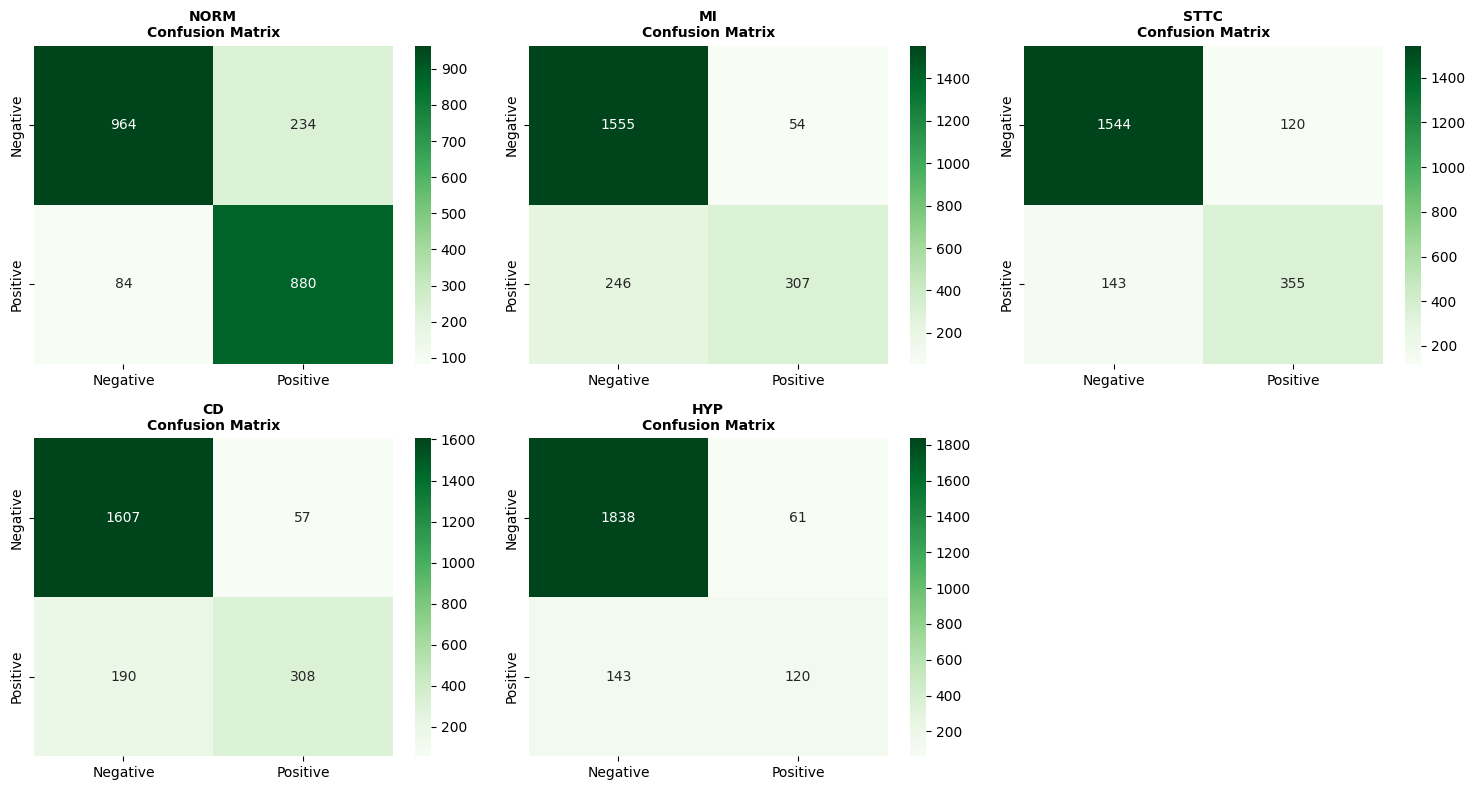

In [69]:
correlation = plot_confusion_matrices_per_class(Y_test, y_pred, SUPERCLASS_NAMES)

In [141]:
def plot_co_occurrence_matrices(Y_test, y_pred, class_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    true_cooccurrence = (Y_test.T @ Y_test).astype(int)
    np.fill_diagonal(true_cooccurrence, 0) 
    
    sns.heatmap(true_cooccurrence, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title('True Labels Co-occurrence Matrix', fontweight='bold', fontsize=12)
    ax1.tick_params(axis='x', rotation=0)
    ax1.tick_params(axis='y', rotation=0)
    
    pred_cooccurrence = (y_pred.T @ y_pred).astype(int)
    np.fill_diagonal(pred_cooccurrence, 0)  
    
    sns.heatmap(pred_cooccurrence, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Predicted Labels Co-occurrence Matrix', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='x', rotation=0)
    ax2.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    return fig

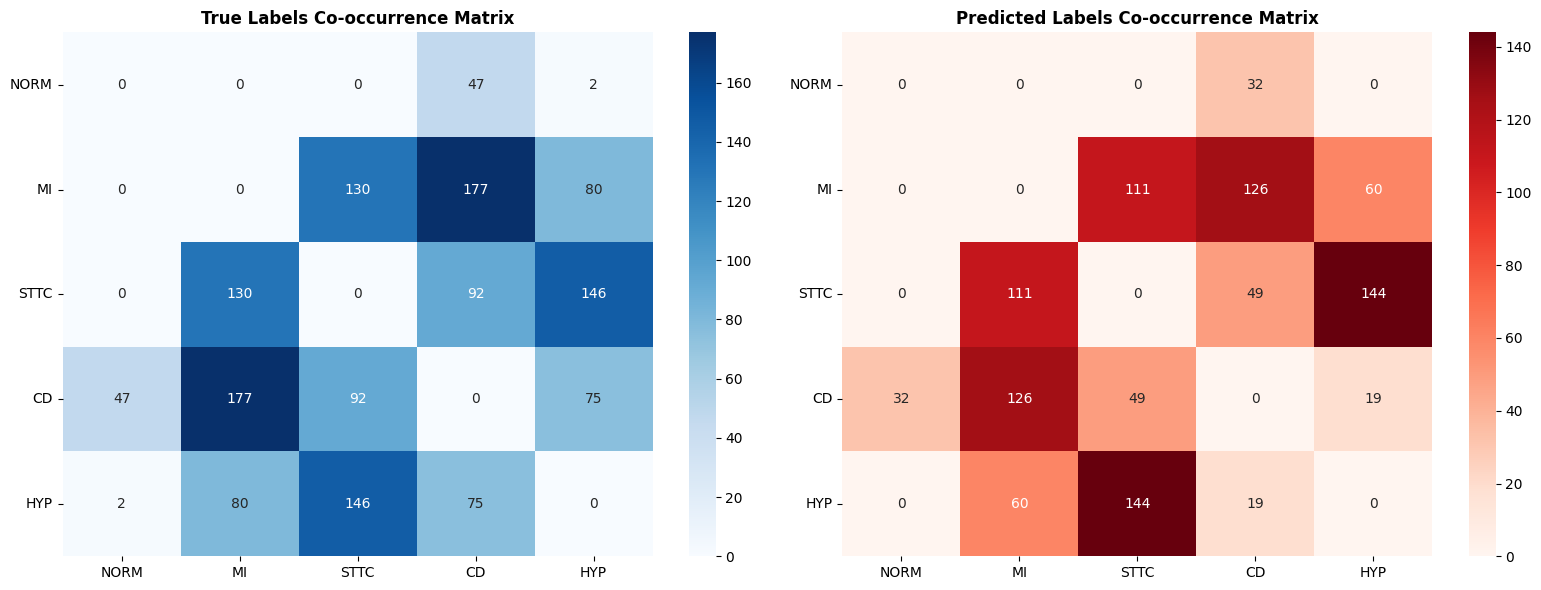

In [70]:
coocurrence = plot_co_occurrence_matrices(Y_test, y_pred, SUPERCLASS_NAMES)

## **Hierarchical xLSTM Classifier** ##

In [157]:
OUTPUT_DIR = '/kaggle/working/Hierarchical/'

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(OUTPUT_DIR, 'checkpoints'),
    filename='hier_xlstm-{epoch:02d}-{val_auc:.4f}',
    save_top_k=1,          
    save_last=False,       
    verbose=False,
    monitor='val_auc',
    mode='max',
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=CONFIG['patience'],
    mode='max',
    verbose=False
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
csv_logger = CSVLogger(save_dir=OUTPUT_DIR, name="logs")

trainer = pl.Trainer(
    max_epochs=CONFIG['epochs'],
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    enable_progress_bar=True,
    enable_model_summary=False,
    logger=csv_logger,
    log_every_n_steps=50,
)

In [73]:
model = HierarchicalParallelxLSTMClassifier(CONFIG)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [82]:
best_model_path = checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")
best_model = HierarchicalParallelxLSTMClassifier.load_from_checkpoint(best_model_path)
best_model.eval()
best_model.freeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

Loading best model from: /kaggle/working/Hierarchical/checkpoints/hier_xlstm-epoch=10-val_auc=0.9172.ckpt


In [76]:
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

with torch.no_grad():
    for x, m, y in test_loader:
        x, m = x.to(device), m.to(device)
        y_pred = best_model(x, m)
        all_y_true.append(y.cpu().numpy())
        all_y_pred_proba.append(y_pred.cpu().numpy())

Y_test = np.concatenate(all_y_true)
y_pred_proba = np.concatenate(all_y_pred_proba)
y_pred = (y_pred_proba > 0.5).astype(int)

In [77]:
overall_auc = roc_auc_score(Y_test, y_pred_proba, average='macro')
overall_precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
overall_recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
overall_f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)
overall_accuracy = accuracy_score(Y_test, y_pred)

micro_auc = roc_auc_score(Y_test, y_pred_proba, average='micro')
micro_precision = precision_score(Y_test, y_pred, average='micro', zero_division=0)
micro_recall = recall_score(Y_test, y_pred, average='micro', zero_division=0)
micro_f1 = f1_score(Y_test, y_pred, average='micro', zero_division=0)
micro_accuracy = accuracy_score(Y_test, y_pred)

weighted_precision = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_recall = recall_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(Y_test, y_pred, average='weighted', zero_division=0)

In [78]:
print(f"{'Metric':<15} {'Macro':>10} {'Micro':>10} {'Weighted':>10}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
print(f"{'AUC':<15} {overall_auc:>10.4f} {micro_auc:>10.4f} {'-':>10}")
print(f"{'Precision':<15} {overall_precision:>10.4f} {micro_precision:>10.4f} {weighted_precision:>10.4f}")
print(f"{'Recall':<15} {overall_recall:>10.4f} {micro_recall:>10.4f} {weighted_recall:>10.4f}")
print(f"{'F1-Score':<15} {overall_f1:>10.4f} {micro_f1:>10.4f} {weighted_f1:>10.4f}")
print(f"{'Accuracy':<15} {overall_accuracy:>10.4f} {micro_accuracy:>10.4f} {'-':>10}")

Metric               Macro      Micro   Weighted
--------------- ---------- ---------- ----------
AUC                 0.9145     0.9263          -
Precision           0.7540     0.7858     0.7876
Recall              0.7063     0.7399     0.7399
F1-Score            0.7282     0.7622     0.7620
Accuracy            0.6050     0.6050          -


In [79]:
print(f"{'Class':<20} {'AUC':>8} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
print("-" * 80)
class_metrics = []
support_per_class = Y_test.sum(axis=0)

for i, class_name in enumerate(SUPERCLASS_NAMES):
    auc = roc_auc_score(Y_test[:, i], y_pred_proba[:, i])
    precision = precision_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    support = support_per_class[i]
    
    print(f"{class_name:<20} {auc:>8.4f} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10.0f}")

print("-" * 80)
print(f"{'MACRO AVG':<20} {overall_auc:>8.4f} {overall_precision:>10.4f} {overall_recall:>10.4f} {overall_f1:>10.4f} {len(Y_test):>10.0f}")

Class                     AUC  Precision     Recall         F1    Support
--------------------------------------------------------------------------------
NORM                   0.9432     0.8581     0.8402     0.8491        964
MI                     0.9250     0.7675     0.7342     0.7505        553
STTC                   0.9278     0.7580     0.7169     0.7368        498
CD                     0.9020     0.8200     0.6586     0.7305        498
HYP                    0.8747     0.5667     0.5817     0.5741        263
--------------------------------------------------------------------------------
MACRO AVG              0.9145     0.7540     0.7063     0.7282       2162


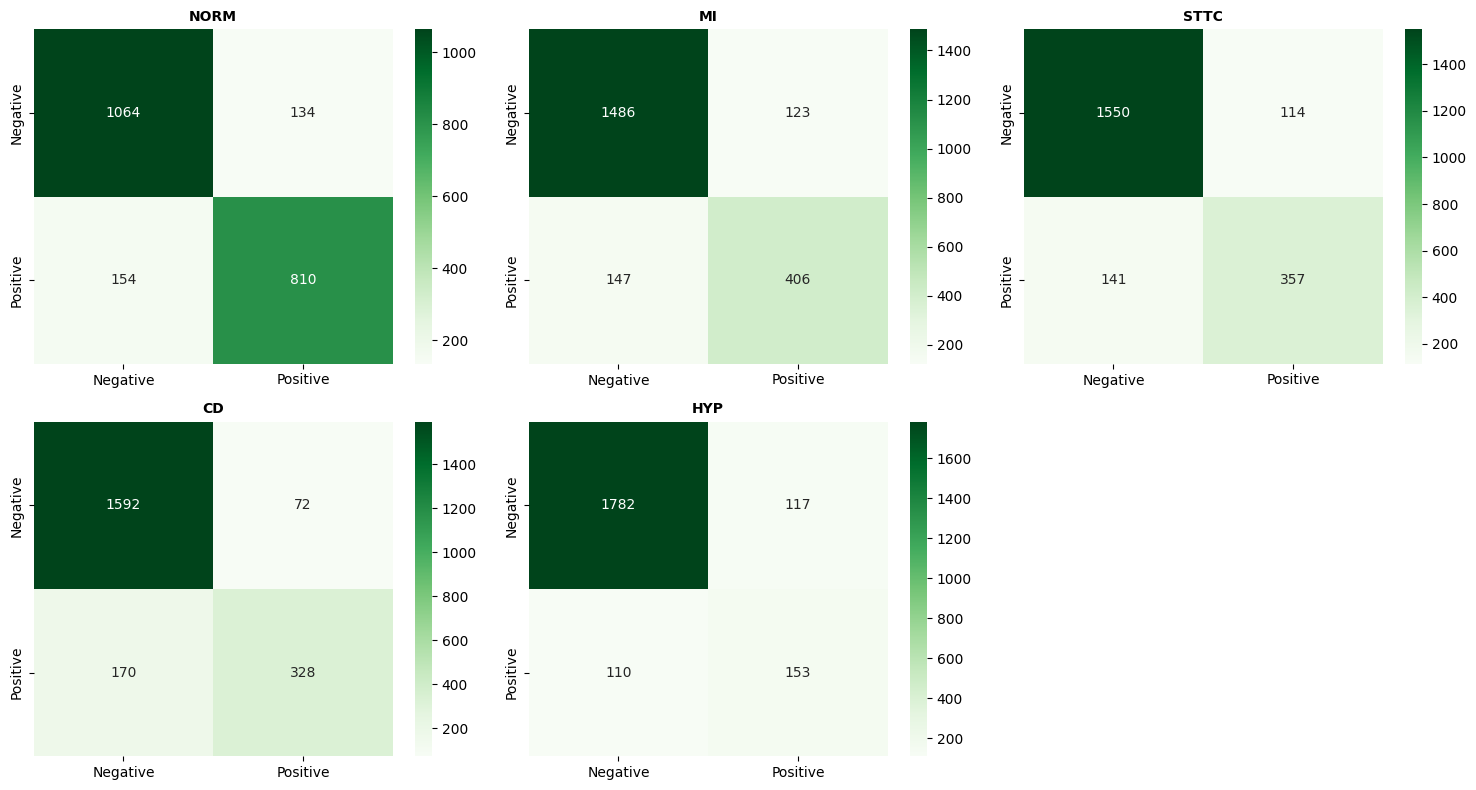

In [80]:
confusion_fig = plot_confusion_matrices_per_class(Y_test, y_pred, SUPERCLASS_NAMES)

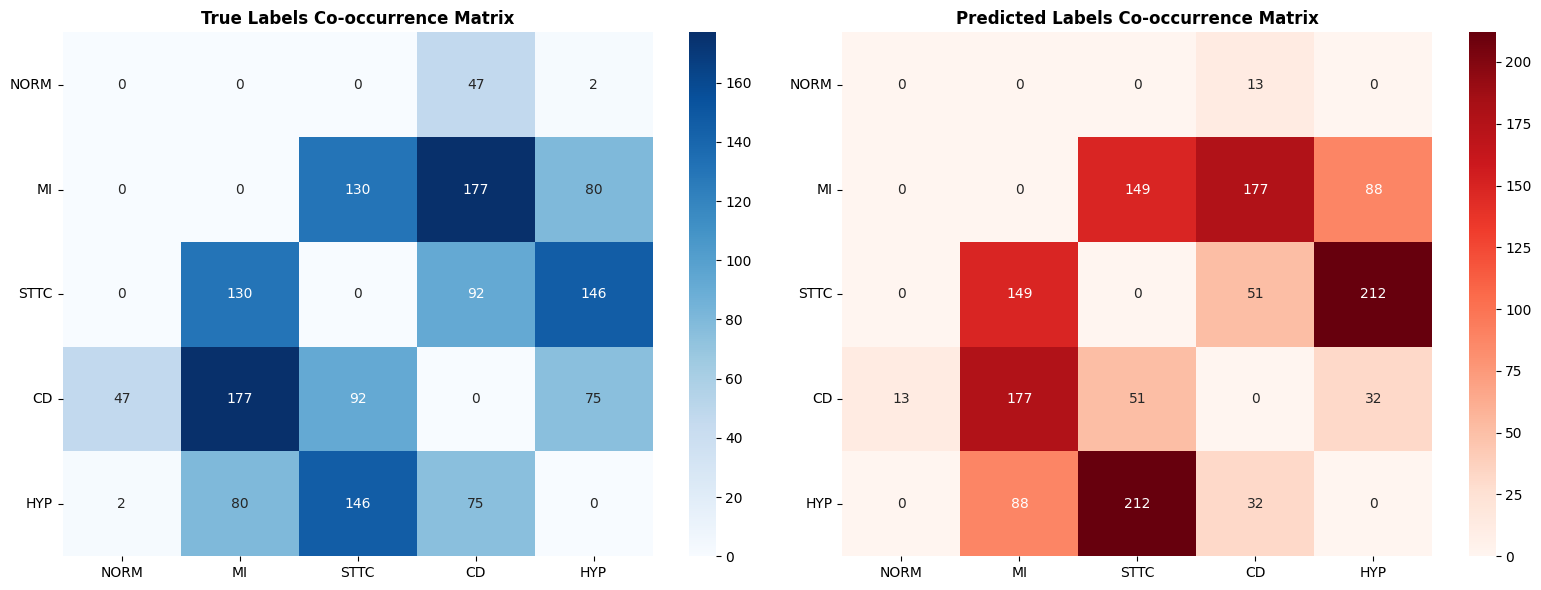

In [81]:
cooccurrence_fig = plot_co_occurrence_matrices(Y_test, y_pred, SUPERCLASS_NAMES)

# **xLSTM with Embedding Length = 256** #

In [158]:
CONFIG = { 
    'input_shape': (1000, 12),
    'num_classes': 5,
    'metadata_dim': 2,
    'embedding_dim': 256,
    'slstm_hidden_size': 128,
    'mlstm_hidden_size': 128,
    'num_heads': 4,
    'dropout': 0.3,
    'batch_size': 32,  
    'epochs': 30,
    'learning_rate': 0.001,
    'patience': 3
}

## **Stacked xLSTM Classifier** ##

In [ ]:
OUTPUT_DIR = '/kaggle/working'
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(OUTPUT_DIR, 'checkpoints'),
    filename='xlstm_100hz_parallel_best-{epoch:02d}-{val_auc:.3f}',
    save_top_k=1,
    save_last=False,  
    verbose=False,    
    monitor='val_auc',
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=CONFIG['patience'],
    mode='max',
    verbose=False  
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
csv_logger = CSVLogger(save_dir=OUTPUT_DIR, name="logs")

trainer = pl.Trainer(
    max_epochs=CONFIG['epochs'],
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    enable_progress_bar=True,     
    enable_model_summary=False,   
    logger=csv_logger,
    log_every_n_steps=50,        
)

In [134]:
model = StackedParallelxLSTMClassifier(CONFIG)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [145]:
best_model_path = checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")
best_model = StackedParallelxLSTMClassifier.load_from_checkpoint(best_model_path)
best_model.eval()
best_model.freeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

Loading best model from: /kaggle/working/checkpoints/xlstm_100hz_parallel_best-epoch=05-val_auc=0.914.ckpt


In [136]:
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

with torch.no_grad():
    for x, m, y in test_loader:
        x, m = x.to(device), m.to(device)
        y_pred = best_model(x, m)
        all_y_true.append(y.cpu().numpy())
        all_y_pred_proba.append(y_pred.cpu().numpy())

Y_test = np.concatenate(all_y_true)
y_pred_proba = np.concatenate(all_y_pred_proba)
y_pred = (y_pred_proba > 0.5).astype(int)

In [137]:
overall_auc = roc_auc_score(Y_test, y_pred_proba, average='macro')
overall_precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
overall_recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
overall_f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)
overall_accuracy = accuracy_score(Y_test, y_pred)

micro_auc = roc_auc_score(Y_test, y_pred_proba, average='micro')
micro_precision = precision_score(Y_test, y_pred, average='micro', zero_division=0)
micro_recall = recall_score(Y_test, y_pred, average='micro', zero_division=0)
micro_f1 = f1_score(Y_test, y_pred, average='micro', zero_division=0)
micro_accuracy = accuracy_score(Y_test, y_pred)

weighted_precision = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_recall = recall_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(Y_test, y_pred, average='weighted', zero_division=0)

In [138]:
print(f"{'Metric':<15} {'Macro':>10} {'Micro':>10} {'Weighted':>10}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
print(f"{'AUC':<15} {overall_auc:>10.4f} {micro_auc:>10.4f} {'-':>10}")
print(f"{'Precision':<15} {overall_precision:>10.4f} {micro_precision:>10.4f} {weighted_precision:>10.4f}")
print(f"{'Recall':<15} {overall_recall:>10.4f} {micro_recall:>10.4f} {weighted_recall:>10.4f}")
print(f"{'F1-Score':<15} {overall_f1:>10.4f} {micro_f1:>10.4f} {weighted_f1:>10.4f}")
print(f"{'Accuracy':<15} {overall_accuracy:>10.4f} {micro_accuracy:>10.4f} {'-':>10}")

Metric               Macro      Micro   Weighted
--------------- ---------- ---------- ----------
AUC                 0.9046     0.9162          -
Precision           0.7753     0.7840     0.7890
Recall              0.6457     0.7115     0.7115
F1-Score            0.6880     0.7460     0.7337
Accuracy            0.6129     0.6129          -


In [139]:
print(f"{'Class':<20} {'AUC':>8} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
print("-" * 80)

class_metrics = []
support_per_class = Y_test.sum(axis=0)

for i, class_name in enumerate(SUPERCLASS_NAMES):
    auc = roc_auc_score(Y_test[:, i], y_pred_proba[:, i])
    precision = precision_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    support = support_per_class[i]
    
    print(f"{class_name:<20} {auc:>8.4f} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10.0f}")

print("-" * 80)
print(f"{'MACRO AVG':<20} {overall_auc:>8.4f} {overall_precision:>10.4f} {overall_recall:>10.4f} {overall_f1:>10.4f} {len(Y_test):>10.0f}")

Class                     AUC  Precision     Recall         F1    Support
--------------------------------------------------------------------------------
NORM                   0.9379     0.8050     0.8994     0.8496        964
MI                     0.9077     0.8588     0.5497     0.6703        553
STTC                   0.9209     0.6930     0.8112     0.7475        498
CD                     0.8870     0.8280     0.6185     0.7080        498
HYP                    0.8697     0.6917     0.3498     0.4646        263
--------------------------------------------------------------------------------
MACRO AVG              0.9046     0.7753     0.6457     0.6880       2162


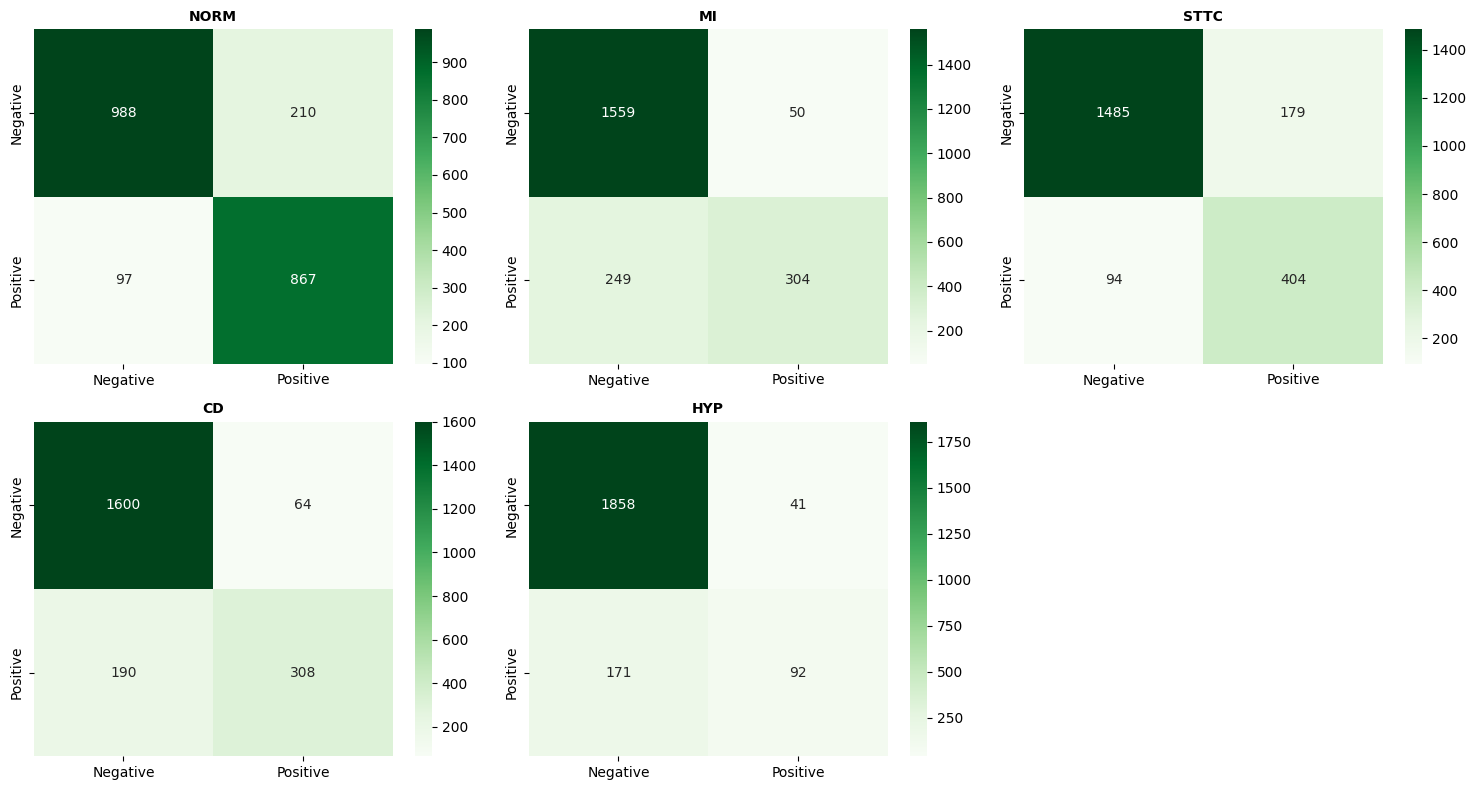

In [142]:
correlation = plot_confusion_matrices_per_class(Y_test, y_pred, SUPERCLASS_NAMES)

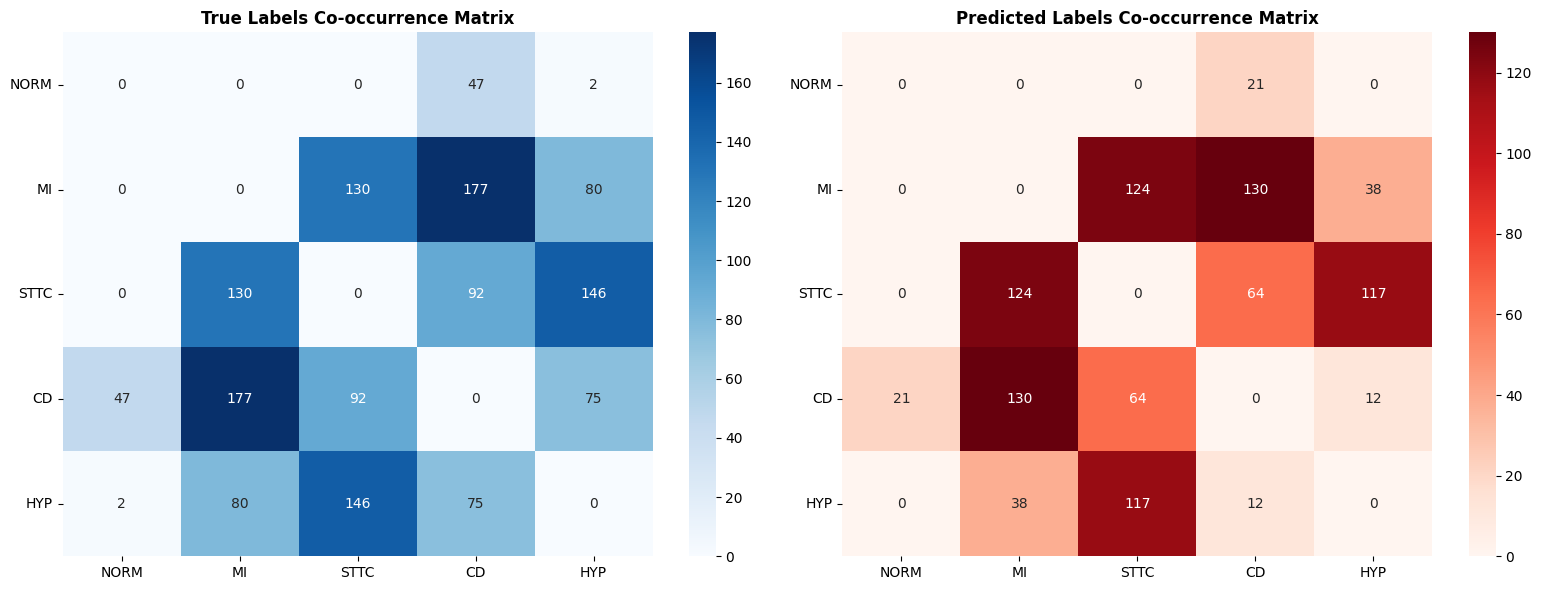

In [143]:
coocurrence = plot_co_occurrence_matrices(Y_test, y_pred, SUPERCLASS_NAMES)

## **Hierarchical xLSTM Classifier** ##

In [ ]:
OUTPUT_DIR = '/kaggle/working/Hierarchical/'

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(OUTPUT_DIR, 'checkpoints'),
    filename='hier_xlstm-{epoch:02d}-{val_auc:.4f}',
    save_top_k=1,          
    save_last=False,   
    verbose=False,
    monitor='val_auc',
    mode='max',
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=CONFIG['patience'],
    mode='max',
    verbose=False
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
csv_logger = CSVLogger(save_dir=OUTPUT_DIR, name="logs")

trainer = pl.Trainer(
    max_epochs=CONFIG['epochs'],
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    enable_progress_bar=True,
    enable_model_summary=False,
    logger=csv_logger,
    log_every_n_steps=50,
)

In [160]:
model = HierarchicalParallelxLSTMClassifier(CONFIG)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [168]:
best_model_path = checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")
best_model = HierarchicalParallelxLSTMClassifier.load_from_checkpoint(best_model_path)
best_model.eval()
best_model.freeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

Loading best model from: /kaggle/working/Hierarchical/checkpoints/hier_xlstm-epoch=05-val_auc=0.9116.ckpt


In [162]:
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

with torch.no_grad():
    for x, m, y in test_loader:
        x, m = x.to(device), m.to(device)
        y_pred = best_model(x, m)
        all_y_true.append(y.cpu().numpy())
        all_y_pred_proba.append(y_pred.cpu().numpy())

Y_test = np.concatenate(all_y_true)
y_pred_proba = np.concatenate(all_y_pred_proba)
y_pred = (y_pred_proba > 0.5).astype(int)

In [163]:
overall_auc = roc_auc_score(Y_test, y_pred_proba, average='macro')
overall_precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
overall_recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
overall_f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)
overall_accuracy = accuracy_score(Y_test, y_pred)

micro_auc = roc_auc_score(Y_test, y_pred_proba, average='micro')
micro_precision = precision_score(Y_test, y_pred, average='micro', zero_division=0)
micro_recall = recall_score(Y_test, y_pred, average='micro', zero_division=0)
micro_f1 = f1_score(Y_test, y_pred, average='micro', zero_division=0)
micro_accuracy = accuracy_score(Y_test, y_pred)

weighted_precision = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_recall = recall_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(Y_test, y_pred, average='weighted', zero_division=0)

In [164]:
print(f"{'Metric':<15} {'Macro':>10} {'Micro':>10} {'Weighted':>10}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
print(f"{'AUC':<15} {overall_auc:>10.4f} {micro_auc:>10.4f} {'-':>10}")
print(f"{'Precision':<15} {overall_precision:>10.4f} {micro_precision:>10.4f} {weighted_precision:>10.4f}")
print(f"{'Recall':<15} {overall_recall:>10.4f} {micro_recall:>10.4f} {weighted_recall:>10.4f}")
print(f"{'F1-Score':<15} {overall_f1:>10.4f} {micro_f1:>10.4f} {weighted_f1:>10.4f}")
print(f"{'Accuracy':<15} {overall_accuracy:>10.4f} {micro_accuracy:>10.4f} {'-':>10}")

Metric               Macro      Micro   Weighted
--------------- ---------- ---------- ----------
AUC                 0.9072     0.9208          -
Precision           0.7497     0.7771     0.7821
Recall              0.6648     0.7032     0.7032
F1-Score            0.7001     0.7383     0.7365
Accuracy            0.5772     0.5772          -


In [165]:
print(f"{'Class':<20} {'AUC':>8} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
print("-" * 80)
class_metrics = []
support_per_class = Y_test.sum(axis=0)

for i, class_name in enumerate(SUPERCLASS_NAMES):
    auc = roc_auc_score(Y_test[:, i], y_pred_proba[:, i])
    precision = precision_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    support = support_per_class[i]
    
    print(f"{class_name:<20} {auc:>8.4f} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10.0f}")

print("-" * 80)
print(f"{'MACRO AVG':<20} {overall_auc:>8.4f} {overall_precision:>10.4f} {overall_recall:>10.4f} {overall_f1:>10.4f} {len(Y_test):>10.0f}")

Class                     AUC  Precision     Recall         F1    Support
--------------------------------------------------------------------------------
NORM                   0.9362     0.8506     0.7915     0.8200        964
MI                     0.9263     0.7673     0.7034     0.7340        553
STTC                   0.9189     0.6920     0.7671     0.7276        498
CD                     0.8988     0.8673     0.5904     0.7025        498
HYP                    0.8558     0.5714     0.4715     0.5167        263
--------------------------------------------------------------------------------
MACRO AVG              0.9072     0.7497     0.6648     0.7001       2162


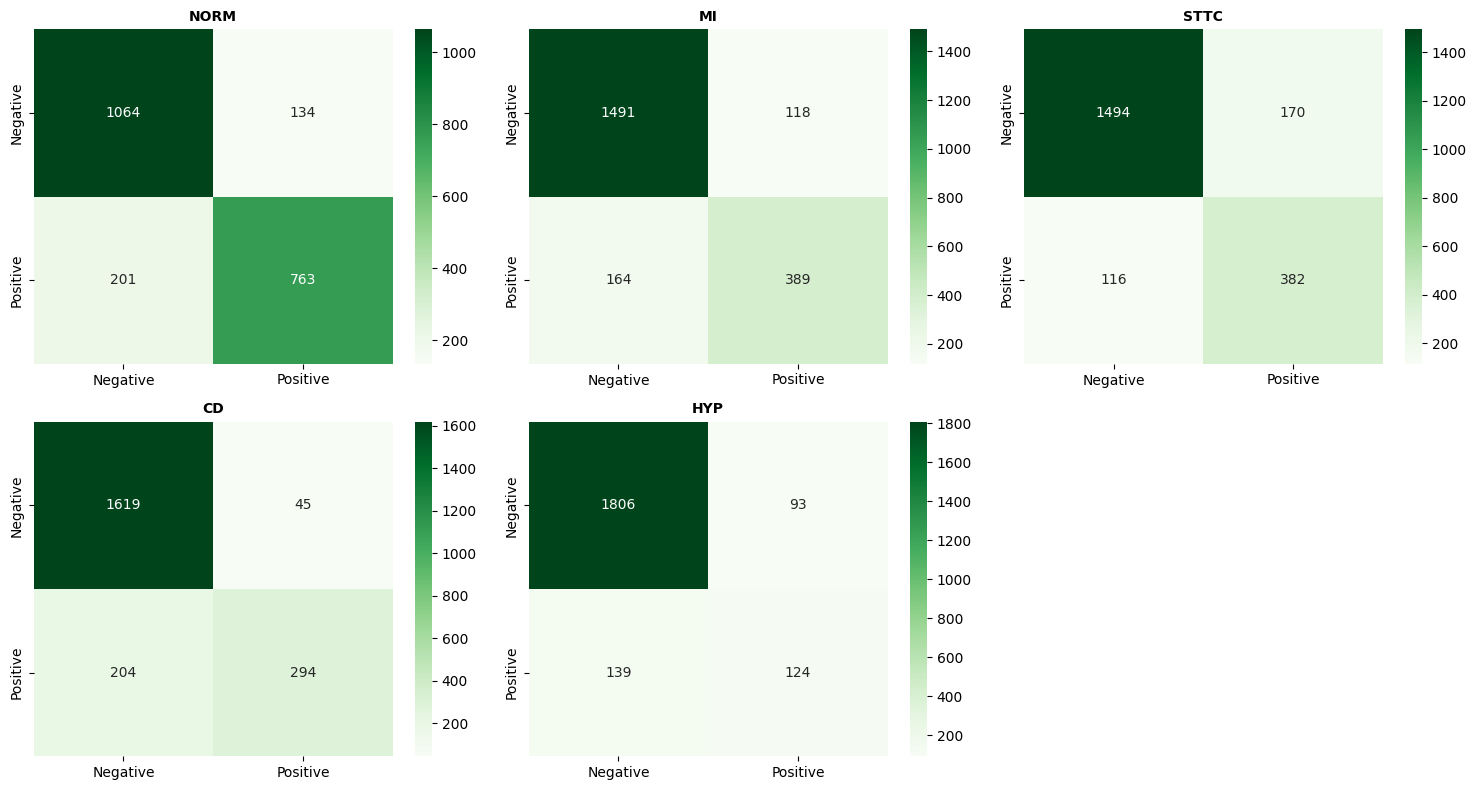

In [166]:
confusion_fig = plot_confusion_matrices_per_class(Y_test, y_pred, SUPERCLASS_NAMES)

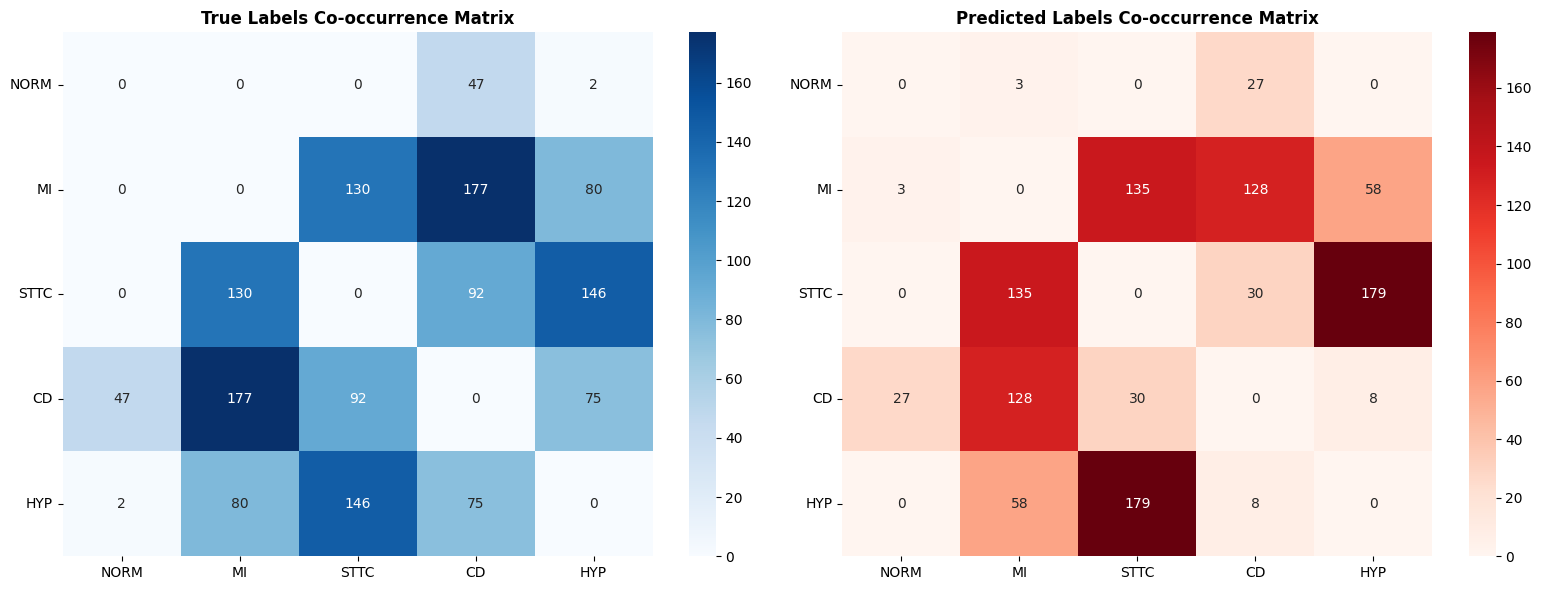

In [167]:
cooccurrence_fig = plot_co_occurrence_matrices(Y_test, y_pred, SUPERCLASS_NAMES)

# **xLSTM with Embedding Length 64** #

In [169]:
CONFIG = { 
    'input_shape': (1000, 12),
    'num_classes': 5,
    'metadata_dim': 2,
    'embedding_dim': 64,
    'num_heads': 4,
    'dropout': 0.3,
    'batch_size': 32,  
    'epochs': 30,
    'learning_rate': 0.001,
    'patience': 3
}

## **Stacked xLSTM Classifier** ##

In [ ]:
OUTPUT_DIR = '/kaggle/working'
checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(OUTPUT_DIR, 'checkpoints'),
    filename='xlstm_100hz_parallel_best-{epoch:02d}-{val_auc:.3f}',
    save_top_k=1,
    save_last=False,  
    verbose=False,    
    monitor='val_auc',
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=CONFIG['patience'],
    mode='max',
    verbose=False  
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
csv_logger = CSVLogger(save_dir=OUTPUT_DIR, name="logs")

trainer = pl.Trainer(
    max_epochs=CONFIG['epochs'],
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    enable_progress_bar=True,     
    enable_model_summary=False,   
    logger=csv_logger,
    log_every_n_steps=50,        
)

In [147]:
model = StackedParallelxLSTMClassifier(CONFIG)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [155]:
best_model_path = checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")
best_model = StackedParallelxLSTMClassifier.load_from_checkpoint(best_model_path)
best_model.eval()
best_model.freeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

Loading best model from: /kaggle/working/checkpoints/xlstm_100hz_parallel_best-epoch=06-val_auc=0.915.ckpt


In [149]:
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

with torch.no_grad():
    for x, m, y in test_loader:
        x, m = x.to(device), m.to(device)
        y_pred = best_model(x, m)
        all_y_true.append(y.cpu().numpy())
        all_y_pred_proba.append(y_pred.cpu().numpy())

Y_test = np.concatenate(all_y_true)
y_pred_proba = np.concatenate(all_y_pred_proba)
y_pred = (y_pred_proba > 0.5).astype(int)

In [150]:
overall_auc = roc_auc_score(Y_test, y_pred_proba, average='macro')
overall_precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
overall_recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
overall_f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)
overall_accuracy = accuracy_score(Y_test, y_pred)

micro_auc = roc_auc_score(Y_test, y_pred_proba, average='micro')
micro_precision = precision_score(Y_test, y_pred, average='micro', zero_division=0)
micro_recall = recall_score(Y_test, y_pred, average='micro', zero_division=0)
micro_f1 = f1_score(Y_test, y_pred, average='micro', zero_division=0)
micro_accuracy = accuracy_score(Y_test, y_pred)

weighted_precision = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_recall = recall_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(Y_test, y_pred, average='weighted', zero_division=0)

In [151]:
print(f"{'Metric':<15} {'Macro':>10} {'Micro':>10} {'Weighted':>10}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
print(f"{'AUC':<15} {overall_auc:>10.4f} {micro_auc:>10.4f} {'-':>10}")
print(f"{'Precision':<15} {overall_precision:>10.4f} {micro_precision:>10.4f} {weighted_precision:>10.4f}")
print(f"{'Recall':<15} {overall_recall:>10.4f} {micro_recall:>10.4f} {weighted_recall:>10.4f}")
print(f"{'F1-Score':<15} {overall_f1:>10.4f} {micro_f1:>10.4f} {weighted_f1:>10.4f}")
print(f"{'Accuracy':<15} {overall_accuracy:>10.4f} {micro_accuracy:>10.4f} {'-':>10}")

Metric               Macro      Micro   Weighted
--------------- ---------- ---------- ----------
AUC                 0.9094     0.9226          -
Precision           0.7783     0.7965     0.7983
Recall              0.6462     0.7021     0.7021
F1-Score            0.6982     0.7463     0.7395
Accuracy            0.6087     0.6087          -


In [152]:
print(f"{'Class':<20} {'AUC':>8} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
print("-" * 80)

class_metrics = []
support_per_class = Y_test.sum(axis=0)

for i, class_name in enumerate(SUPERCLASS_NAMES):
    auc = roc_auc_score(Y_test[:, i], y_pred_proba[:, i])
    precision = precision_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    support = support_per_class[i]
    
    print(f"{class_name:<20} {auc:>8.4f} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10.0f}")

print("-" * 80)
print(f"{'MACRO AVG':<20} {overall_auc:>8.4f} {overall_precision:>10.4f} {overall_recall:>10.4f} {overall_f1:>10.4f} {len(Y_test):>10.0f}")

Class                     AUC  Precision     Recall         F1    Support
--------------------------------------------------------------------------------
NORM                   0.9402     0.8451     0.8600     0.8524        964
MI                     0.9149     0.7062     0.7649     0.7344        553
STTC                   0.9253     0.8263     0.5924     0.6901        498
CD                     0.8947     0.8567     0.5763     0.6891        498
HYP                    0.8719     0.6571     0.4373     0.5251        263
--------------------------------------------------------------------------------
MACRO AVG              0.9094     0.7783     0.6462     0.6982       2162


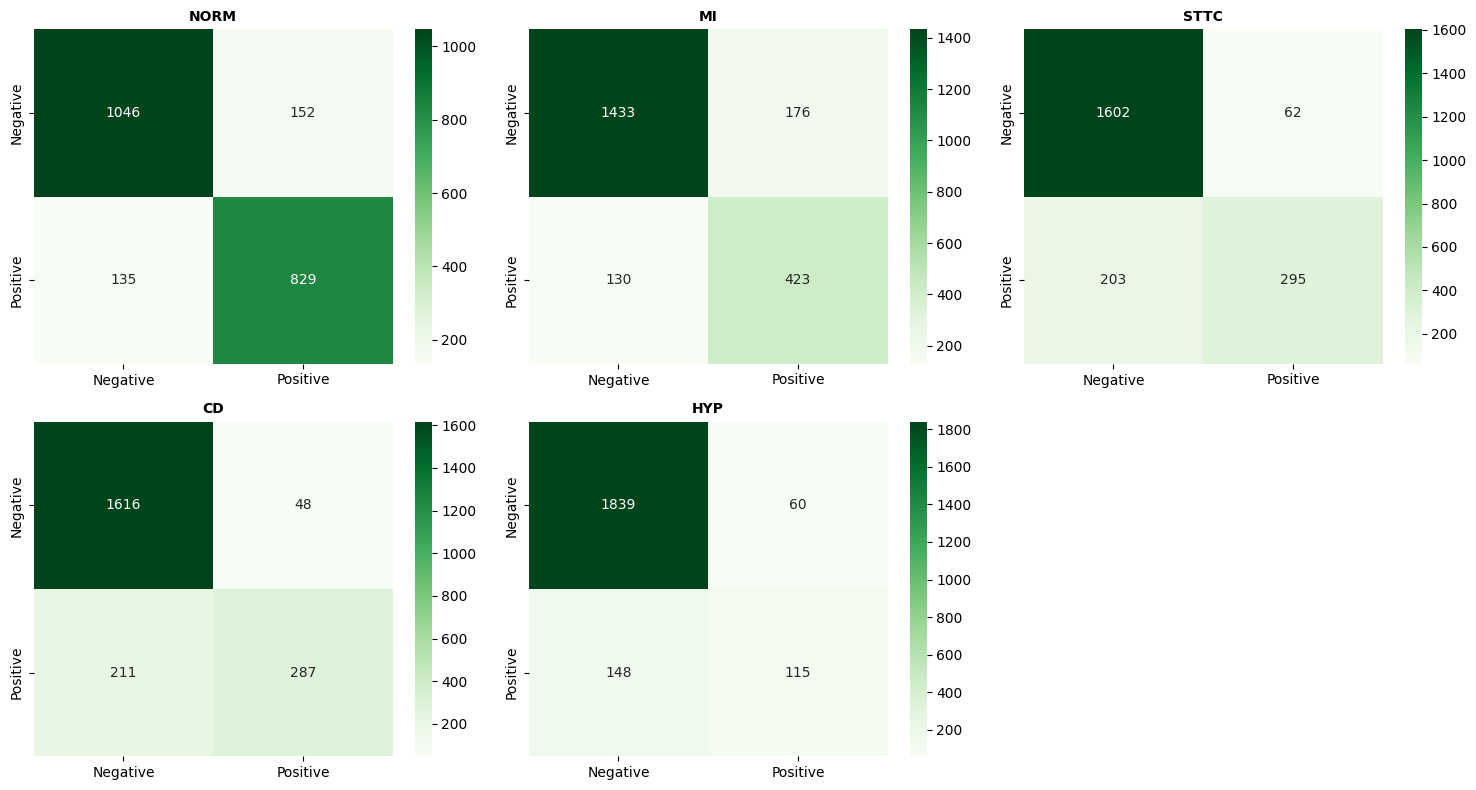

In [153]:
correlation = plot_confusion_matrices_per_class(Y_test, y_pred, SUPERCLASS_NAMES)

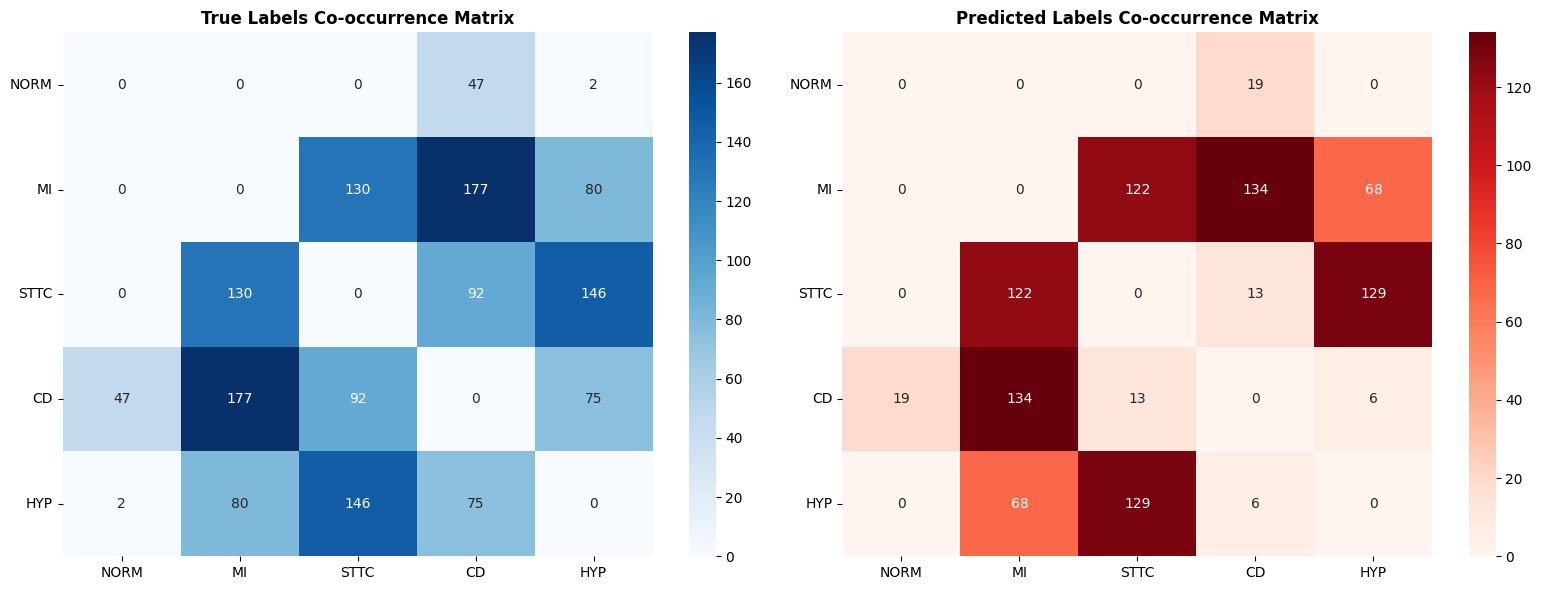

In [154]:
coocurrence = plot_co_occurrence_matrices(Y_test, y_pred, SUPERCLASS_NAMES)

## **Hierarchical xLSTM Classifier** ##

In [ ]:
OUTPUT_DIR = '/kaggle/working/Hierarchical/'

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(OUTPUT_DIR, 'checkpoints'),
    filename='hier_xlstm-{epoch:02d}-{val_auc:.4f}',
    save_top_k=1,          
    save_last=False,    
    verbose=False,
    monitor='val_auc',
    mode='max',
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=CONFIG['patience'],
    mode='max',
    verbose=False
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')
csv_logger = CSVLogger(save_dir=OUTPUT_DIR, name="logs")

trainer = pl.Trainer(
    max_epochs=CONFIG['epochs'],
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    enable_progress_bar=True,
    enable_model_summary=False,
    logger=csv_logger,
    log_every_n_steps=50,
)

In [171]:
model = HierarchicalParallelxLSTMClassifier(CONFIG)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [179]:
best_model_path = checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")
best_model = HierarchicalParallelxLSTMClassifier.load_from_checkpoint(best_model_path)
best_model.eval()
best_model.freeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

Loading best model from: /kaggle/working/Hierarchical/checkpoints/hier_xlstm-epoch=06-val_auc=0.9140.ckpt


In [173]:
all_y_true = []
all_y_pred = []
all_y_pred_proba = []

with torch.no_grad():
    for x, m, y in test_loader:
        x, m = x.to(device), m.to(device)
        y_pred = best_model(x, m)
        all_y_true.append(y.cpu().numpy())
        all_y_pred_proba.append(y_pred.cpu().numpy())

Y_test = np.concatenate(all_y_true)
y_pred_proba = np.concatenate(all_y_pred_proba)
y_pred = (y_pred_proba > 0.5).astype(int)

In [174]:
overall_auc = roc_auc_score(Y_test, y_pred_proba, average='macro')
overall_precision = precision_score(Y_test, y_pred, average='macro', zero_division=0)
overall_recall = recall_score(Y_test, y_pred, average='macro', zero_division=0)
overall_f1 = f1_score(Y_test, y_pred, average='macro', zero_division=0)
overall_accuracy = accuracy_score(Y_test, y_pred)

micro_auc = roc_auc_score(Y_test, y_pred_proba, average='micro')
micro_precision = precision_score(Y_test, y_pred, average='micro', zero_division=0)
micro_recall = recall_score(Y_test, y_pred, average='micro', zero_division=0)
micro_f1 = f1_score(Y_test, y_pred, average='micro', zero_division=0)
micro_accuracy = accuracy_score(Y_test, y_pred)

weighted_precision = precision_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_recall = recall_score(Y_test, y_pred, average='weighted', zero_division=0)
weighted_f1 = f1_score(Y_test, y_pred, average='weighted', zero_division=0)

In [175]:
print(f"{'Metric':<15} {'Macro':>10} {'Micro':>10} {'Weighted':>10}")
print(f"{'-'*15} {'-'*10} {'-'*10} {'-'*10}")
print(f"{'AUC':<15} {overall_auc:>10.4f} {micro_auc:>10.4f} {'-':>10}")
print(f"{'Precision':<15} {overall_precision:>10.4f} {micro_precision:>10.4f} {weighted_precision:>10.4f}")
print(f"{'Recall':<15} {overall_recall:>10.4f} {micro_recall:>10.4f} {weighted_recall:>10.4f}")
print(f"{'F1-Score':<15} {overall_f1:>10.4f} {micro_f1:>10.4f} {weighted_f1:>10.4f}")
print(f"{'Accuracy':<15} {overall_accuracy:>10.4f} {micro_accuracy:>10.4f} {'-':>10}")

Metric               Macro      Micro   Weighted
--------------- ---------- ---------- ----------
AUC                 0.9083     0.9217          -
Precision           0.7406     0.7718     0.7727
Recall              0.6897     0.7248     0.7248
F1-Score            0.7125     0.7475     0.7466
Accuracy            0.5907     0.5907          -


In [176]:
print(f"{'Class':<20} {'AUC':>8} {'Precision':>10} {'Recall':>10} {'F1':>10} {'Support':>10}")
print("-" * 80)
class_metrics = []
support_per_class = Y_test.sum(axis=0)

for i, class_name in enumerate(SUPERCLASS_NAMES):
    auc = roc_auc_score(Y_test[:, i], y_pred_proba[:, i])
    precision = precision_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(Y_test[:, i], y_pred[:, i], zero_division=0)
    support = support_per_class[i]
    
    print(f"{class_name:<20} {auc:>8.4f} {precision:>10.4f} {recall:>10.4f} {f1:>10.4f} {support:>10.0f}")

print("-" * 80)
print(f"{'MACRO AVG':<20} {overall_auc:>8.4f} {overall_precision:>10.4f} {overall_recall:>10.4f} {overall_f1:>10.4f} {len(Y_test):>10.0f}")

Class                     AUC  Precision     Recall         F1    Support
--------------------------------------------------------------------------------
NORM                   0.9425     0.8584     0.7988     0.8275        964
MI                     0.9137     0.7500     0.6835     0.7152        553
STTC                   0.9208     0.6973     0.7771     0.7350        498
CD                     0.8914     0.8000     0.6988     0.7460        498
HYP                    0.8728     0.5972     0.4905     0.5386        263
--------------------------------------------------------------------------------
MACRO AVG              0.9083     0.7406     0.6897     0.7125       2162


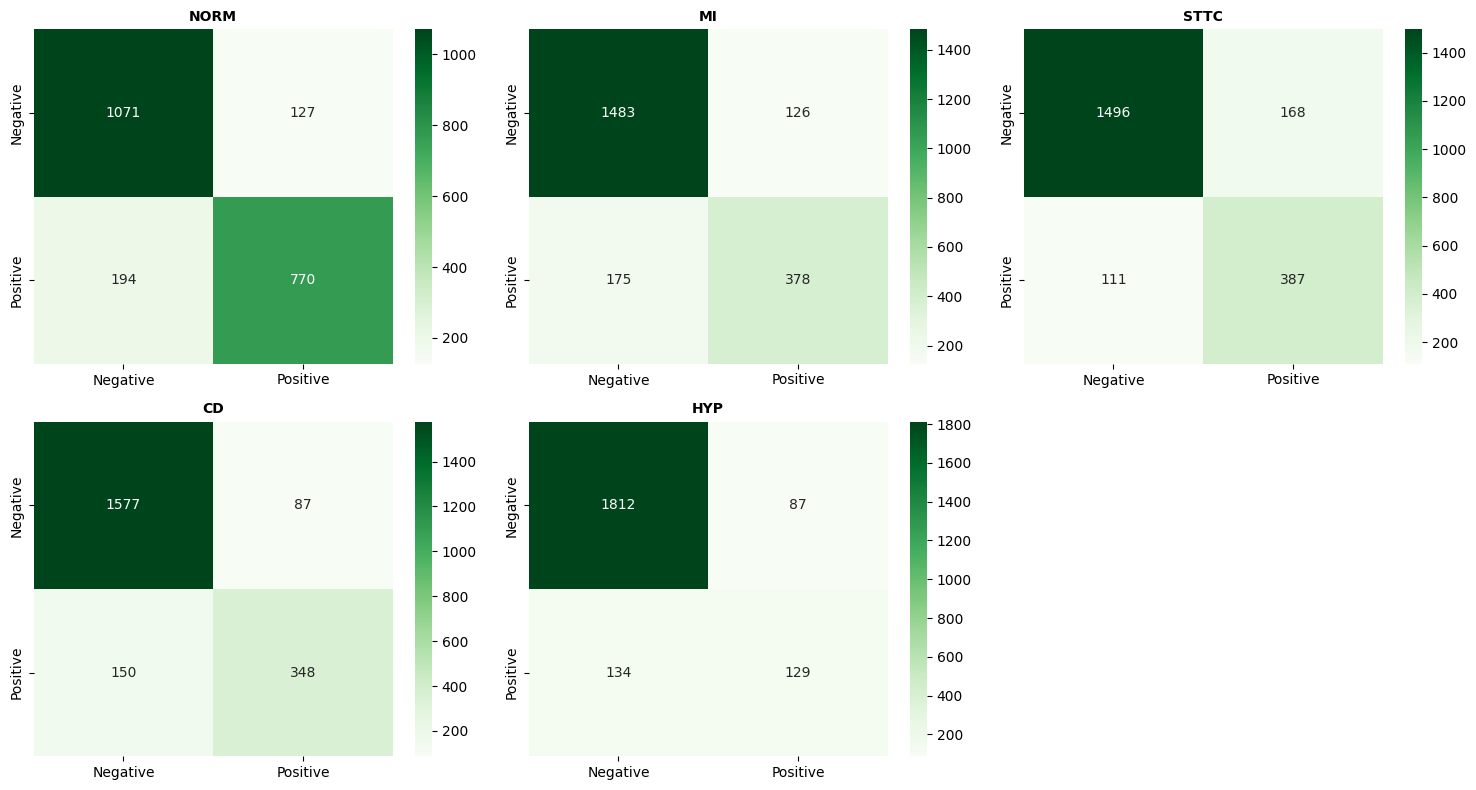

In [177]:
confusion_fig = plot_confusion_matrices_per_class(Y_test, y_pred, SUPERCLASS_NAMES)

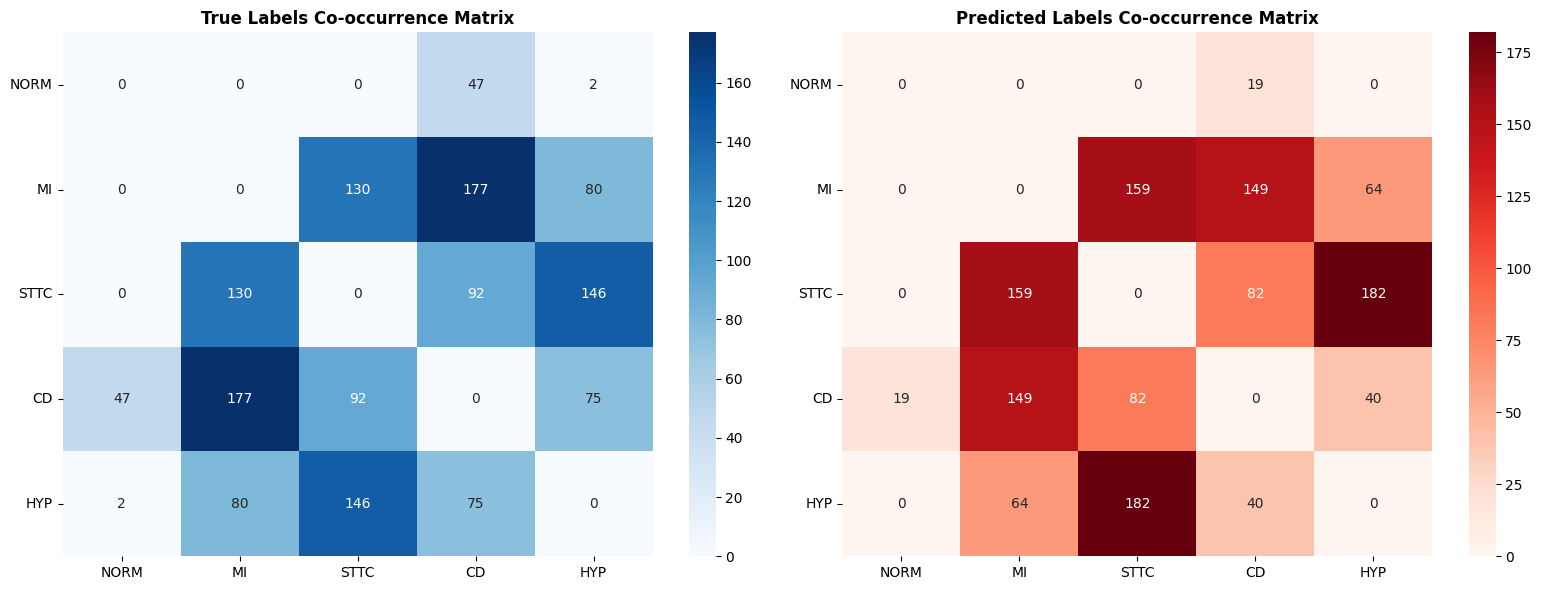

In [178]:
cooccurrence_fig = plot_co_occurrence_matrices(Y_test, y_pred, SUPERCLASS_NAMES)